In [1]:
"""
Loading frameworks
"""

import cv2
import glob
from IPython.display import HTML
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np


In [2]:
"""
Importing test image and initializing the data
"""

straight_lines_image = cv2.imread('./test_images/straight_lines1.jpg')
image_size = (straight_lines_image.shape[1], straight_lines_image.shape[0])

print('Image size = {}'.format(image_size))


Image size = (1280, 720)


In [3]:
"""
Useful functions
"""

def show_image(image, cmap=None):
    """
    Displays an image
    """
    plt.imshow(image, cmap=cmap)
    plt.show()
    
def read_image(image_name):
    image = cv2.imread(image_name)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

In [4]:
"""
Camera calibration
"""

def draw_chessboard_corners(image, corners, pattern_size, ret):
    """
    Draws chessboard corners over the image and displays a result
    """
    image = cv2.drawChessboardCorners(image, pattern_size, corners, ret)
    show_image(image)

def calibrate_camera(image_names, pattern_size=(9, 6), show_corners=False):
    """
    Calibrates the camera based on images set with chessboards patterns provided.
    Returns camera calibration matrix and distortion coefficients
    """
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
    
    image_size = None
    
    for image_name in image_names:
        image = cv2.imread(image_name)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if image_size is None:
            image_size = gray.shape[::-1]
        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)
        
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            if show_corners:
                draw_chessboard_corners(image, corners, pattern_size, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    return mtx, dist

def undistort_image(image, mtx, dist):
    """
    Undistorts an image based on camera calibration matrix and distortion coefficients
    """
    return cv2.undistort(image, mtx, dist, None, mtx)

def show_undistorted_images(image_names, mtx, dist):
    """
    Displays undistorted versions of input images
    """
    for image_name in image_names:
        image = cv2.imread(image_name)
        image = undistort_image(image, mtx, dist)
        show_image(image)
            

In [5]:
"""
Loading camera calibration images and calculating calibration matrix and distortion coefficients
"""

calibration_images = glob.glob('./camera_cal/calibration*.jpg')
calibration_mtx, calibration_dist = calibrate_camera(calibration_images, pattern_size=(9, 6), show_corners=False)


In [25]:
"""
Sobel gradients
"""

def apply_sobel_thresh(gray, orient='x', thresh=(0, 255), kernel_size=3):
    """
    Applies a Sobel threshold with given orientation x or y
    """
    if orient == 'x':
        orient_num = (1, 0)
    elif orient == 'y':
        orient_num = (0, 1)

    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient_num[0], orient_num[1], ksize=kernel_size))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

def apply_direction_sobel(gray, kernel_size=15, thresh=(0.7, 1.3)):
    """
    Applies a direction Sobel threshold
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_grad = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(abs_grad)
    binary_output[(abs_grad >= thresh[0]) & (abs_grad <= thresh[1])] = 1
    return binary_output

def apply_magnitude_sobel(gray, kernel_size=3, thresh=(10, 60)):
    """
    Applies a magnitude Sobel threshold
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def blur_image(image, kernel_size=7):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def thresh_gray_image(gray, thresh=(140, 255)):
    ret, gray = cv2.threshold(gray, thresh[0], thresh[1], cv2.THRESH_TOZERO)
    return gray

def combine_magnitude_and_direction(gray, mag_thresh=(10, 60), dir_thresh=(0.7, 1.3)):
    mag_binary = apply_magnitude_sobel(gray, thresh=mag_thresh)
    dir_binary = apply_direction_sobel(gray, thresh=dir_thresh)
    binary_output = np.zeros_like(mag_binary)
    binary_output[(mag_binary == 1) & (dir_binary == 1)] = 1
    return binary_output

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def apply_mask(image):
    left_bottom = [120, 720]
    right_bottom = [1160, 720]
    # left_apex = [460, 500]
    # right_apex = [820, 500]
    
    left_apex = [460, 470]
    right_apex = [820, 470]
    vertices = np.array([[left_bottom, left_apex, right_apex, right_bottom]], dtype=np.int32) #right_subapex, left_subapex, left_subbottom
                         
    return region_of_interest(image, vertices)

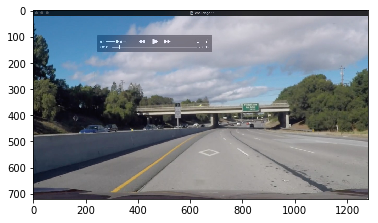

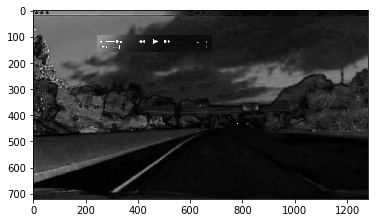

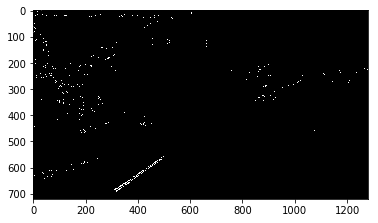

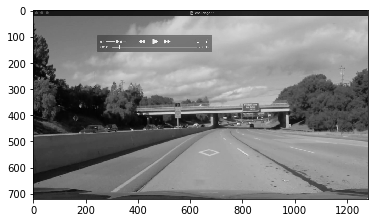

(77932985.0, 0.0, 0.0, 0.0)


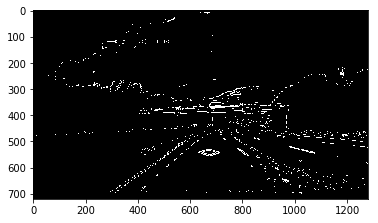

In [7]:

image = read_image('./test_images/challenge1.jpg')
show_image(image)

s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
show_image(s_channel,cmap='gray')
gray = thresh_gray_image(s_channel, thresh=(95, 255))
gray = combine_magnitude_and_direction(gray, mag_thresh=(10, 150), dir_thresh=(0.9, 1.1))
show_image(gray, cmap='gray')

blurred = blur_image(image)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
show_image(gray, cmap='gray')
gray = thresh_gray_image(gray, thresh=(140, 255))
print(cv2.sumElems(gray))
#gray = thresh_gray_image(gray, thresh=(40, 255))

img = apply_magnitude_sobel(gray, kernel_size=3, thresh=(10, 60))
show_image(img, cmap='gray')

In [8]:
"""
Color thresholding
"""
def apply_hls_thresh(image, thresh=(70, 255)):
    """
    Applies a threshold for Saturation layer of image in HLS color space
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


In [9]:

def combine_sobel_and_hls(image):
    blurred = blur_image(image)
    gray = cv2.cvtColor(blurred, cv2.COLOR_RGB2GRAY)
    threshed = thresh_gray_image(gray)
    sobel_binary = combine_magnitude_and_direction(threshed)
    masked = apply_mask(sobel_binary)
    
    sumElems = cv2.sumElems(masked)[0]
    if sumElems < 1000:
        threshed = thresh_gray_image(gray, thresh=(30, 255))
        sobel_binary = combine_magnitude_and_direction(threshed, mag_thresh=(10, 50), dir_thresh=(0.8, 1.2))
        masked = apply_mask(sobel_binary)
    
    s_channel = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]
    s_threshed = thresh_gray_image(s_channel, thresh=(95, 255))
    hls_binary = combine_magnitude_and_direction(s_threshed, mag_thresh=(10, 150), dir_thresh=(0.9, 1.1))
    s_masked = apply_mask(hls_binary)
       
    binary_output = np.zeros_like(sobel_binary)
    binary_output[(masked == 1) | (s_masked == 1)] = 1
    return binary_output


In [10]:


def test_func(image, show_plot=False):
    image = blur_image(image, kernel_size=9)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    l_channel = hls[:, :, 1]
    
    thresh = [150, 255]
    #s_binary_output = np.zeros_like(s_channel)
    #s_binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    #s_threshed = thresh_gray_image(s_channel, thresh=(95, 255))
    s_binary_output = apply_sobel_thresh(s_channel, orient='x', thresh=(20, 100), kernel_size=5)
    # s_binary_output = combine_magnitude_and_direction(s_channel, mag_thresh=(20, 100), dir_thresh=(0.7, 1.3))
    if show_plot:
        show_image(s_binary_output, cmap='gray')
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # show_image(gray, cmap='gray')
    threshed_m = apply_magnitude_sobel(gray, kernel_size=3, thresh=(20, 100))
    # show_image(threshed_m, cmap='gray')
    threshed_d = apply_direction_sobel(gray, kernel_size=15, thresh=(0.8, 1.2))
    # show_image(threshed_d, cmap='gray')
    
    sobelx = apply_sobel_thresh(gray, orient='x', thresh=(20, 100), kernel_size=7)
    if show_plot:
        show_image(sobelx, cmap='gray')
    threshed = np.zeros_like(threshed_m)
    threshed[((threshed_m == 1) & (threshed_d == 1)) & (sobelx == 1)] = 1
    if show_plot:
        show_image(threshed, cmap='gray')
    
    thresh = [150, 255]
    l_binary_output = np.zeros_like(l_channel)
    l_binary_output[(l_channel >= thresh[0]) & (l_channel <= thresh[1])] = 1
    # show_image(l_binary_output, cmap='gray')

    s_l = np.zeros_like(l_binary_output)
    s_l[((threshed == 1) & (l_binary_output == 1)) | (s_binary_output == 1)] = 1
    if show_plot:
        show_image(s_l, cmap='gray')
    return s_l

image = read_image('./test_images/hard2.jpg')
test_func(image)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
"""
Perspective transformation
"""

def get_perspective_transform(src, dst):
    """
    Calculates a matrix of perspective transformation from src to dst points
    """
    return cv2.getPerspectiveTransform(src, dst)

def warp_perspective(image, M, image_size):
    """
    Returns a warped image after applying a perspective transformation
    """
    return cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)


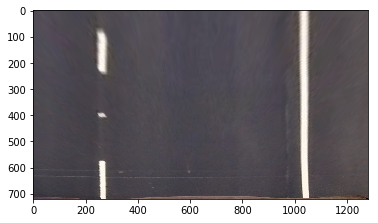

In [26]:
"""
Calculate a perspective matrix
"""

image = read_image('./test_images/straight_lines2.jpg')
# src = np.float32([[589, 454], [695, 454], [1048, 682], [275, 682]])
# dst = np.float32([[272, 0], [1037, 0], [1037, 720], [272, 720]])

# src = np.float32([[558, 476], [730, 476], [1048, 682], [275, 682]])

# src = np.float32([[460, 546], [836, 546], [1048, 682], [275, 682]])
# dst = np.float32([[272, 0], [1037, 0], [1037, 720], [272, 720]])

    
src = np.float32([[568, 470], [721, 470], [1048, 682], [275, 682]])
dst = np.float32([[272, 0], [1037, 0], [1037, 720], [272, 720]])

perspective_M = get_perspective_transform(src, dst)
perspective_Minv = get_perspective_transform(dst, src)

def test_perspective(image, M, image_size):
    image = warp_perspective(image, M, image_size)
    show_image(image)

test_perspective(image, perspective_M, image_size)
    

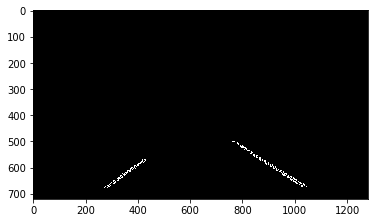

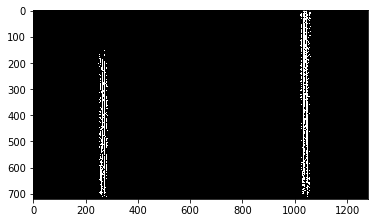

In [13]:

image = read_image('./test_images/straight_lines2.jpg')
# warped = combine_magnitude_and_dir(image)
warped = combine_sobel_and_hls(image)
show_image(warped, cmap='gray')

warped = warp_perspective(warped, perspective_M, image_size)
show_image(warped, cmap='gray')

In [14]:

def sliding_window_search(binary_warped, show_plot=False):
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = 200 + np.argmax(histogram[200:(midpoint-220)])
    rightx_base = np.argmax(histogram[(midpoint+220):-200]) + midpoint + 220
    
    lmax = np.amax(histogram[:(midpoint)])
    rmax = np.amax(histogram[(midpoint):])
    
    '''
    if lmax < 50 or rmax < 50:
        histogram = np.sum(binary_warped[:,:], axis=0)
        if lmax < 50:
            leftx_base = np.argmax(histogram[:midpoint])
        if rmax < 50:
            rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        """
        window_width = 50 
        window = np.ones(window_width) # Create our window template that we will use for convolutions
    
        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 
    
        # Sum quarter bottom of image to get slice, could use a different ratio
        if lmax < 50:
            l_sum = np.sum(warped[int(0*binary_warped.shape[0]/4):,:int(binary_warped.shape[1]/2)], axis=0)
            #leftx_base = int(np.argmax(np.convolve(window,l_sum))-window_width/2)
            leftx_base = int(np.argmax(np.convolve(window,l_sum))-window_width/2)
        if rmax < 50:
            r_sum = np.sum(warped[int(0*binary_warped.shape[0]/4):,int(binary_warped.shape[1]/2):], axis=0)
            rightx_base = int(np.argmax(np.convolve(window,r_sum))-window_width/2+int(binary_warped.shape[1]/2))
        """
    '''
    if show_plot:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if show_plot:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(lefty) > 0 and len(leftx) > 1500:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
        
    if len(righty) > 0 and len(rightx) > 1500:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None

    if show_plot and left_fit is not None and right_fit is not None:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
            
    return left_fit, right_fit
    

def search_points_knowing_polys(binary_warped, left_fit, right_fit, show_plot=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if len(lefty) > 0 and len(leftx) > 1500:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
        
    if len(righty) > 0 and len(rightx) > 1500:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
        
    last_y = (binary_warped.shape[0] - 1)
    if left_fit is not None:
        first_left_x = left_fit[2]
        last_left_x = left_fit[0] * last_y**2 + left_fit[1] * last_y + left_fit[2]
        if first_left_x > (3*binary_warped.shape[1]//4) or last_left_x < 130:
            left_fit = None
    if right_fit is not None:
        first_right_x = right_fit[2]
        last_right_x = right_fit[0] * last_y**2 + right_fit[1] * last_y + right_fit[2]
        if first_right_x < (binary_warped.shape[1]//4) or last_right_x > 1150:
            right_fit = None
    
    if show_plot and left_fit is not None and right_fit is not None:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    return left_fit, right_fit
    
def sliding_window_search2(warped):
    # window settings
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    def window_mask(width, height, img_ref, center,level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    def find_window_centroids(image, window_width, window_height, margin):
        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions
    
        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 
    
        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(2*warped.shape[0]/2):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(2*warped.shape[0]/2):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))
    
        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        return window_centroids

    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found %%!
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    

In [15]:

def draw_lines(image, warped, image_size, Minv, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped, np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (image_size[0], image_size[1])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, new_warp, 0.3, 0)
    return result


In [16]:

def full_process_image(image, image_size, mtx, dist, M, Minv, show_plot=False):
    undistorted = undistort_image(image, mtx, dist)
    threshed = test_func(undistorted)
    #threshed = combine_sobel_and_hls(undistorted)
    #masked = apply_mask(threshed)
    if show_plot:
        show_image(threshed, cmap='gray')
    warped = warp_perspective(threshed, M, image_size)
    if show_plot:
        show_image(warped, cmap='gray')
    left_fit, right_fit = sliding_window_search(warped, show_plot)
    # sliding_window_search2(warped)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    if show_plot:
        print(left_fit)
        print(right_fit)
    res = draw_lines(undistorted, warped, image_size, Minv, left_fitx, right_fitx, ploty)
    return res
    
def process_image(image):
    return full_process_image(image, image_size, calibration_mtx, calibration_dist, perspective_M, perspective_Minv)


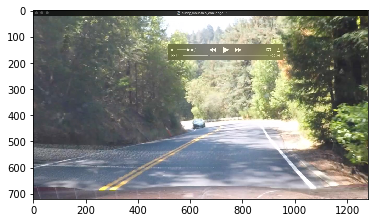

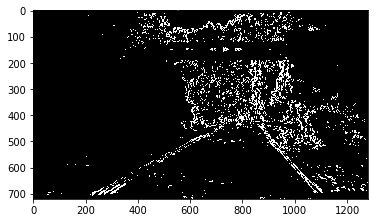

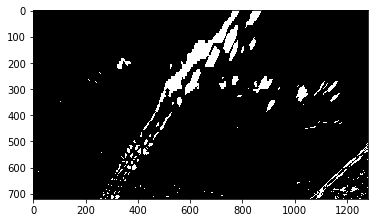

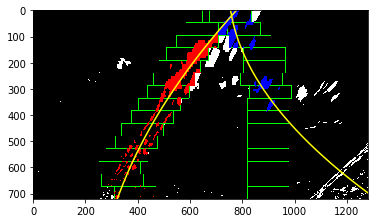

[  3.80245842e-04  -9.05328082e-01   7.76994073e+02]
[  8.50147206e-04   1.59790246e-01   7.55211370e+02]


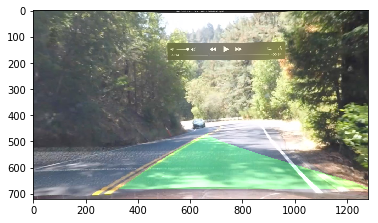

In [29]:

image = read_image('./test_images/hard2.jpg')
show_image(image)
show_image(full_process_image(image, image_size, calibration_mtx, calibration_dist, perspective_M, perspective_Minv, show_plot=True))


In [53]:

class Lane():
    def __init__(self, n, image_size=(1280, 720), lane_type='r'):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = None
        # average x values of the fitted line over the last n iterations
        self.bestx = None     
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # radius of curvature of the line in some units
        self.radius_of_curvature = None 
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        
        self.n = n
        self.image_size = image_size
        self.lane_type = lane_type
        
    def append_x(self, new_x, new_y):
        self.allx = new_x
        self.ally = new_y
        
        if self.recent_xfitted is not None and self.recent_xfitted.shape[0] > self.n:
            self.recent_xfitted = np.delete(self.recent_xfitted, 0, axis=0)
        
        if self.recent_xfitted is None:
            self.recent_xfitted = np.vstack([new_x])
        else:
            self.recent_xfitted = np.vstack([self.recent_xfitted, new_x])
        
        self.bestx = np.mean(self.recent_xfitted, axis=0)
        if len(self.bestx) > 0:
            new_fit = np.polyfit(self.ally, self.bestx, 2)
            if self.best_fit is None:
                self.best_fit = new_fit
            else:
                self.diffs = np.absolute(np.subtract(self.best_fit, new_fit))
                if self.diffs[0] < 5e-4:# and self.diffs[1] < 5e-1 and self.diffs[2] < 5:
                    self.best_fit = new_fit
                print(self.diffs)
            
            

In [47]:
left_lane = None
right_lane = None
def init_lanes():
    global left_lane
    left_lane = Lane(10, lane_type='l')
    global right_lane 
    right_lane = Lane(10, lane_type='r')


In [48]:

def process_video_image(image):
    undistorted = undistort_image(image, calibration_mtx, calibration_dist)
    threshed = test_func(undistorted)
    # threshed = combine_sobel_and_hls(undistorted)
    warped = warp_perspective(threshed, perspective_M, image_size)
    
    if left_lane.detected == False or right_lane.detected == False:
        left_fit, right_fit = sliding_window_search(warped, show_plot=False)
    else:
        left_fit, right_fit = search_points_knowing_polys(warped, left_lane.best_fit, 
                                                          right_lane.best_fit, show_plot=False)
        if left_fit is None or right_fit is None:
            left_fit, right_fit = sliding_window_search(warped, show_plot=False)
        
    if left_fit is not None:
        left_lane.current_fit = left_fit[:]
        left_lane.detected = True
    else:
        left_lane.detected = False
        
    if right_fit is not None:
        right_lane.current_fit = right_fit[:]
        right_lane.detected = True
    else:
        right_lane.detected = False
        
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0])

    if left_fit is not None:
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        left_lane.append_x(left_fitx, ploty)
    if right_fit is not None:
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        right_lane.append_x(right_fitx, ploty)
        
    if left_lane.best_fit is not None and right_lane.best_fit is not None:
        left_fitx = left_lane.best_fit[0] * ploty**2 + left_lane.best_fit[1] * ploty + left_lane.best_fit[2]
        right_fitx = right_lane.best_fit[0] * ploty**2 + right_lane.best_fit[1] * ploty + right_lane.best_fit[2]
        res = draw_lines(undistorted, warped, image_size, perspective_Minv, left_fitx, right_fitx, ploty)
        # show_image(res)
        return res
    
    return undistorted


In [49]:

def process_video(video_clip_name, output_clip_name):
    init_lanes()
    video_clip = VideoFileClip(video_clip_name)
    output_clip = video_clip.fl_image(process_video_image)
    %time output_clip.write_videofile(output_clip_name, audio=False)



In [33]:

process_video('./project_video.mp4', './output_videos/project_video.mp4')


[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [06:00<00:00,  3.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

CPU times: user 6min 23s, sys: 31.4 s, total: 6min 55s
Wall time: 6min


In [ ]:

process_video('./challenge_video.mp4', './output_videos/challenge_video_output.mp4')


[MoviePy] >>>> Building video ./output_videos/challenge_video_output.mp4
[MoviePy] Writing video ./output_videos/challenge_video_output.mp4





  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<02:28,  3.25it/s]

[  1.33130901e-06   2.07490449e-04   3.11377928e-01]
[  2.21988119e-07   3.08691838e-03   1.74557237e+00]




  0%|          | 2/485 [00:00<02:25,  3.31it/s]

[  1.34119286e-05   1.13967973e-02   1.79471826e+00]
[  6.86054869e-06   5.49559473e-03   6.93496676e-01]




  1%|          | 3/485 [00:00<02:24,  3.35it/s]

[  1.56458861e-05   1.58469301e-02   3.92921819e+00]
[  6.92094193e-06   6.54663555e-03   7.28700003e-01]




  1%|          | 4/485 [00:01<02:21,  3.39it/s]

[  1.48538012e-05   1.44891015e-02   3.00900071e+00]
[  1.14037890e-06   3.49160653e-04   2.32390147e-01]




  1%|          | 5/485 [00:01<02:19,  3.45it/s]

[  1.25106983e-05   1.38652899e-02   3.57985005e+00]
[  5.48108239e-06   3.18269309e-03   6.88379750e-01]




  1%|          | 6/485 [00:01<02:17,  3.49it/s]

[  8.63530014e-08   1.64682232e-04   2.87053815e-01]
[  1.89891166e-05   1.32721750e-02   2.12372132e+00]




  1%|▏         | 7/485 [00:02<02:15,  3.52it/s]

[  5.98658708e-06   4.02329510e-03   3.56262558e-02]
[  1.69192305e-05   1.18581141e-02   2.02096560e+00]




  2%|▏         | 8/485 [00:02<02:20,  3.39it/s]

[  2.41873926e-06   3.08770863e-03   1.24025208e+00]
[  1.03926577e-05   7.50268229e-03   1.30868900e+00]




  2%|▏         | 9/485 [00:02<02:20,  3.38it/s]

[  3.94998193e-07   1.49312368e-03   1.10121558e+00]
[  6.74820300e-06   5.28911106e-03   1.09639988e+00]




  2%|▏         | 10/485 [00:02<02:17,  3.46it/s]

[  2.78232982e-06   2.12161857e-03   1.39584362e-01]
[  4.94016909e-06   4.35698532e-03   9.93516386e-01]




  2%|▏         | 11/485 [00:03<02:18,  3.43it/s]

[  5.11974239e-06   5.09452390e-03   8.96820248e-01]
[  1.02829646e-05   7.70954725e-03   1.39127145e+00]




  2%|▏         | 12/485 [00:03<02:19,  3.40it/s]

[  4.10054713e-07   1.27220590e-03   4.17871082e-01]
[  8.06496971e-06   5.38590023e-03   4.85593727e-01]




  3%|▎         | 13/485 [00:03<02:18,  3.41it/s]

[  6.49092363e-07   8.07042425e-04   1.73086058e-01]
[  1.06037940e-05   7.52429914e-03   8.26261683e-01]




  3%|▎         | 14/485 [00:04<02:19,  3.38it/s]

[  2.06484052e-06   1.21471653e-03   8.78923930e-03]
[  1.74246486e-05   1.33005092e-02   1.53597705e+00]




  3%|▎         | 15/485 [00:04<02:16,  3.45it/s]

[  1.51592708e-05   1.57253796e-02   3.91215201e+00]
[  1.22403100e-05   9.17091301e-03   9.97769994e-01]




  3%|▎         | 16/485 [00:04<02:19,  3.36it/s]

[  6.07209927e-07   4.62007833e-04   3.87641130e-01]
[  1.00976497e-05   8.20638443e-03   8.91183081e-01]




  4%|▎         | 17/485 [00:05<02:22,  3.28it/s]

[  1.13509351e-05   1.18120317e-02   3.37642162e+00]
[  5.76233014e-07   6.28067566e-04   4.81211893e-01]




  4%|▎         | 18/485 [00:05<02:20,  3.33it/s]

[  8.63669227e-06   1.19056705e-02   4.52665570e+00]
[  2.40338739e-06   3.16586739e-04   1.22898997e-01]




  4%|▍         | 19/485 [00:05<02:20,  3.33it/s]

[  2.12110628e-05   2.54916052e-02   8.28419470e+00]
[  8.93340185e-07   2.38824645e-03   4.69878174e-01]




  4%|▍         | 20/485 [00:05<02:19,  3.33it/s]

[  2.09167726e-05   2.52151875e-02   8.29472323e+00]
[  2.17849810e-06   3.80565783e-03   9.94607004e-01]




  4%|▍         | 21/485 [00:06<02:19,  3.33it/s]

[  1.27486251e-05   1.67078444e-02   6.47415925e+00]
[  9.19153186e-06   1.03773744e-02   2.54176390e+00]




  5%|▍         | 22/485 [00:06<02:14,  3.43it/s]

[  1.10645659e-05   1.48352684e-02   5.69460646e+00]
[  8.87956406e-06   1.09313987e-02   3.42901331e+00]




  5%|▍         | 23/485 [00:06<02:12,  3.50it/s]

[  1.94027610e-05   2.21007409e-02   7.29077377e+00]
[  8.34486378e-06   1.03864926e-02   3.32161778e+00]




  5%|▍         | 24/485 [00:07<02:09,  3.55it/s]

[  2.88263887e-05   3.12551719e-02   9.06718198e+00]
[  6.55138474e-06   9.95644741e-03   3.90956147e+00]




  5%|▌         | 25/485 [00:07<02:10,  3.52it/s]

[  3.18302893e-05   3.41524340e-02   9.59022466e+00]
[  7.41560389e-06   8.04776579e-04   2.65135020e+00]




  5%|▌         | 26/485 [00:07<02:09,  3.55it/s]

[  2.95511437e-05   3.02316448e-02   7.65715384e+00]
[  7.40472768e-06   4.46263245e-04   3.85596849e+00]




  6%|▌         | 27/485 [00:07<02:06,  3.61it/s]

[  2.55337438e-05   2.75673848e-02   7.56207822e+00]
[  8.11496794e-06   1.51253771e-03   3.13303746e+00]




  6%|▌         | 28/485 [00:08<02:06,  3.61it/s]

[  2.58440348e-05   2.81614047e-02   7.58135451e+00]
[  7.21929023e-06   3.48286773e-04   4.54019623e+00]




  6%|▌         | 29/485 [00:08<02:09,  3.53it/s]

[  3.11672918e-05   3.14821504e-02   7.62393845e+00]
[  6.55143787e-06   1.26846376e-03   3.37649008e+00]




  6%|▌         | 30/485 [00:08<02:11,  3.45it/s]

[  2.35484887e-05   2.19252816e-02   4.63935162e+00]
[  9.96460111e-06   5.13949321e-03   2.71686308e+00]




  6%|▋         | 31/485 [00:09<02:11,  3.44it/s]

[  1.40540341e-06   2.33810734e-03   6.59590974e-01]
[  5.02388201e-06   5.18506416e-04   3.68939386e+00]




  7%|▋         | 32/485 [00:09<02:10,  3.46it/s]

[  1.03911223e-05   8.28716070e-03   1.39787731e+00]
[  1.92478121e-05   1.23696422e-02   1.00504844e+00]




  7%|▋         | 33/485 [00:09<02:12,  3.42it/s]

[  5.04039188e-06   4.11057642e-03   9.63535439e-01]
[  2.85117171e-05   1.99188331e-02   4.66636974e-01]




  7%|▋         | 34/485 [00:09<02:11,  3.42it/s]

[  8.90390245e-07   8.95415924e-04   1.96083095e-01]
[  2.76697513e-05   1.66792271e-02   9.20493815e-01]




  7%|▋         | 35/485 [00:10<02:12,  3.41it/s]

[  5.91312373e-06   5.30222656e-03   7.64568800e-01]
[  5.94226968e-05   3.81843636e-02   2.47426771e+00]




  7%|▋         | 36/485 [00:10<02:11,  3.42it/s]

[  8.61808798e-06   1.01134111e-02   2.57062742e+00]
[  6.15887139e-05   4.09937379e-02   2.92121126e+00]




  8%|▊         | 37/485 [00:10<02:11,  3.41it/s]

[  1.42341253e-05   1.35289765e-02   2.37390665e+00]
[  6.59215609e-05   4.80679041e-02   5.27185296e+00]




  8%|▊         | 38/485 [00:11<02:11,  3.39it/s]

[  1.03903090e-05   1.12944860e-02   2.60047411e+00]
[  7.47967135e-05   5.61752623e-02   6.31818136e+00]




  8%|▊         | 39/485 [00:11<02:10,  3.42it/s]

[  5.34129502e-06   8.19301007e-03   2.03066511e+00]
[  7.06306601e-05   5.43982237e-02   6.80887059e+00]




  8%|▊         | 40/485 [00:11<02:07,  3.48it/s]

[  2.03806683e-05   2.16495258e-02   4.56860194e+00]
[  6.04669414e-05   4.55012111e-02   4.81977786e+00]




  8%|▊         | 41/485 [00:11<02:06,  3.52it/s]

[  1.10103897e-05   1.18455222e-02   1.79213588e+00]
[  3.96236325e-05   3.31002596e-02   4.10381240e+00]




  9%|▊         | 42/485 [00:12<02:04,  3.56it/s]

[  1.94200124e-05   1.75490693e-02   4.80853297e+00]
[  3.92413548e-05   3.74601327e-02   5.43885528e+00]




  9%|▉         | 43/485 [00:12<02:02,  3.60it/s]

[  2.80220881e-06   8.55922293e-05   1.93067992e+00]
[  2.52288624e-05   2.80105110e-02   3.97543771e+00]




  9%|▉         | 44/485 [00:12<02:02,  3.61it/s]

[  6.05530905e-06   6.68465464e-03   2.88568591e+00]
[  1.18930527e-05   1.85388242e-02   2.62302422e+00]




  9%|▉         | 45/485 [00:13<02:01,  3.63it/s]

[  8.75691127e-06   8.31773262e-03   9.31986892e-01]
[  1.05403555e-05   2.12303027e-02   3.62533600e+00]




  9%|▉         | 46/485 [00:13<02:00,  3.66it/s]

[  1.75879708e-05   1.95171392e-02   6.25579168e+00]
[  2.52628181e-05   1.25406241e-03   1.30709601e+00]




 10%|▉         | 47/485 [00:13<01:59,  3.68it/s]

[  2.06113419e-05   2.21426656e-02   6.92330423e+00]
[  3.91002740e-05   1.35421164e-02   4.19742597e-01]




 10%|▉         | 48/485 [00:13<01:58,  3.69it/s]

[  1.73263265e-05   2.04052642e-02   7.28986286e+00]
[  4.53411949e-05   2.00226230e-02   1.43548583e+00]




 10%|█         | 49/485 [00:14<01:59,  3.66it/s]

[  1.85206928e-05   2.22952503e-02   7.88464775e+00]
[  5.52277586e-05   2.79405199e-02   2.42739358e+00]




 10%|█         | 50/485 [00:14<01:58,  3.67it/s]

[  8.95587722e-06   1.85102948e-03   3.09130009e+00]
[  5.26663737e-05   2.60829898e-02   2.08390257e+00]




 11%|█         | 51/485 [00:14<01:58,  3.65it/s]

[  2.85691102e-06   2.20241617e-03   3.21903863e+00]
[  4.46060539e-05   1.89232502e-02   2.31361518e-01]




 11%|█         | 52/485 [00:14<01:58,  3.66it/s]

[  2.04948722e-05   1.43751669e-02   7.10752718e-01]
[  2.97133195e-05   1.07922663e-02   1.11051069e-01]




 11%|█         | 53/485 [00:15<01:57,  3.67it/s]

[  3.28455973e-05   2.43766963e-02   2.54860776e+00]
[  1.59328861e-05   6.91932799e-04   1.84571456e+00]




 11%|█         | 54/485 [00:15<01:57,  3.68it/s]

[  9.33286312e-06   5.68809934e-03   7.78361417e-01]
[  1.23859035e-05   8.80567032e-04   2.43152071e+00]




 11%|█▏        | 55/485 [00:15<01:57,  3.67it/s]

[  2.13671908e-05   1.51822042e-02   5.56147394e-01]
[  1.01751916e-05   2.01689796e-03   2.76447599e+00]




 12%|█▏        | 56/485 [00:15<01:57,  3.66it/s]

[  1.53111615e-05   6.51552600e-03   2.61413547e+00]
[  1.29731201e-05   5.67092731e-04   2.64234750e+00]




 12%|█▏        | 57/485 [00:16<01:56,  3.66it/s]

[  5.01639571e-05   4.12650594e-02   5.81979073e+00]
[  6.68343897e-06   4.43369994e-03   3.19450823e+00]




 12%|█▏        | 58/485 [00:16<01:56,  3.66it/s]

[  5.89247250e-05   4.94253181e-02   7.85002573e+00]
[  2.91020418e-06   8.44817060e-03   4.03690641e+00]




 12%|█▏        | 59/485 [00:16<01:56,  3.67it/s]

[  4.96894775e-05   4.45367907e-02   8.60012657e+00]
[  3.98504448e-06   6.58818612e-03   3.42460272e+00]




 12%|█▏        | 60/485 [00:17<01:55,  3.68it/s]

[  4.46730635e-05   3.99728375e-02   7.43074446e+00]
[  9.26782614e-06   9.95656784e-04   2.81874598e+00]




 13%|█▎        | 61/485 [00:17<01:55,  3.66it/s]

[  2.26302522e-05   2.17383015e-02   4.59625787e+00]
[  6.87163304e-06   3.46781893e-03   3.89986602e+00]




 13%|█▎        | 62/485 [00:17<01:56,  3.64it/s]

[  1.71425844e-05   1.51604249e-02   2.40926190e+00]
[  7.64033749e-06   2.58402230e-03   4.11115901e+00]




 13%|█▎        | 63/485 [00:17<01:56,  3.62it/s]

[  1.43218135e-05   1.26726039e-02   2.01369979e+00]
[  2.74869957e-05   2.27338703e-02   6.49412857e+00]




 13%|█▎        | 64/485 [00:18<01:56,  3.61it/s]

[  3.05929525e-06   3.24341821e-03   4.14565395e-01]
[  9.79443814e-06   6.80588881e-04   3.22542160e+00]




 13%|█▎        | 65/485 [00:18<01:56,  3.61it/s]

[  1.30019820e-05   1.09529623e-02   1.87780666e+00]
[  2.13136583e-06   3.45489728e-03   3.35887047e+00]




 14%|█▎        | 66/485 [00:18<01:55,  3.63it/s]

[  1.47553002e-05   1.24384161e-02   2.33777099e+00]
[  9.41107217e-06   1.13441166e-03   2.73637197e+00]




 14%|█▍        | 67/485 [00:19<01:54,  3.65it/s]

[  1.53332120e-05   1.47331473e-02   3.60278233e+00]
[  1.75389250e-05   1.86852210e-02   5.66520016e+00]




 14%|█▍        | 68/485 [00:19<01:54,  3.64it/s]

[  1.60491907e-05   1.56638566e-02   4.09240451e+00]
[  5.38189461e-06   9.13408932e-03   4.15604307e+00]




 14%|█▍        | 69/485 [00:19<01:55,  3.61it/s]

[  2.92202494e-05   2.50395746e-02   5.15739715e+00]
[  1.43716514e-05   1.61517059e-02   5.21206547e+00]




 14%|█▍        | 70/485 [00:19<01:56,  3.57it/s]

[  3.31872212e-05   2.64386825e-02   4.40195609e+00]
[  1.37445468e-05   1.69645913e-02   6.06048349e+00]




 15%|█▍        | 71/485 [00:20<01:56,  3.55it/s]

[  4.15219674e-05   3.32280741e-02   5.41316165e+00]
[  1.39538165e-05   1.70298522e-02   5.84775054e+00]




 15%|█▍        | 72/485 [00:20<01:55,  3.58it/s]

[  4.80126611e-05   3.58783157e-02   4.31541490e+00]
[  1.38592374e-05   1.67119384e-02   5.84843686e+00]




 15%|█▌        | 73/485 [00:20<01:54,  3.60it/s]

[  3.89025103e-05   3.06278166e-02   4.70993736e+00]
[  1.82078183e-05   2.08502666e-02   6.39359892e+00]




 15%|█▌        | 74/485 [00:20<01:54,  3.59it/s]

[  4.20042199e-05   3.17768431e-02   3.93015423e+00]
[  1.74705821e-05   2.82700355e-04   4.27811139e+00]




 15%|█▌        | 75/485 [00:21<01:55,  3.54it/s]

[  6.20836145e-05   4.76266279e-02   5.82239855e+00]
[  1.17352625e-05   1.59564287e-02   6.13428153e+00]




 16%|█▌        | 76/485 [00:21<01:58,  3.46it/s]

[  3.50017630e-05   2.43467881e-02   3.00472463e+00]




 16%|█▌        | 77/485 [00:21<01:56,  3.51it/s]

[  2.62704158e-05   1.61108816e-02   1.05424590e+00]




 16%|█▌        | 78/485 [00:22<01:55,  3.54it/s]

[  1.83401406e-05   9.50094866e-03   3.28233117e-02]




 16%|█▋        | 79/485 [00:22<01:54,  3.54it/s]

[  8.14602158e-06   3.22252658e-03   1.68175673e-01]
[  1.67079901e-06   9.25545327e-03   6.37845595e+00]




 16%|█▋        | 80/485 [00:22<01:54,  3.52it/s]

[  8.38587249e-06   7.41158201e-03   5.44035837e-01]
[  9.44480536e-06   1.68472247e-02   7.64564381e+00]




 17%|█▋        | 81/485 [00:22<01:53,  3.57it/s]

[  2.31101324e-06   3.83748580e-03   3.06175737e-01]
[  3.36715811e-05   1.52978948e-02   2.76334863e+00]




 17%|█▋        | 82/485 [00:23<01:52,  3.58it/s]

[  1.09927724e-05   9.15664237e-03   2.44261792e+00]
[  1.60366692e-05   2.78517217e-03   5.07645362e+00]




 17%|█▋        | 83/485 [00:23<01:52,  3.56it/s]

[  1.30437653e-05   1.08073584e-02   2.25182843e+00]
[  2.09662537e-05   7.45521356e-03   4.52042635e+00]




 17%|█▋        | 84/485 [00:23<01:53,  3.54it/s]

[  5.00599463e-06   1.26020078e-03   1.82941311e+00]
[  2.48946686e-05   1.19257149e-02   3.36967043e+00]




 18%|█▊        | 85/485 [00:24<01:52,  3.54it/s]

[  4.86825268e-06   5.26257233e-03   1.71354631e+00]
[  1.63440390e-05   5.90431758e-03   4.02453551e+00]




 18%|█▊        | 86/485 [00:24<01:52,  3.56it/s]

[  2.34050640e-05   1.87617202e-02   2.62374770e+00]
[  2.06421972e-05   1.18255200e-02   2.05601632e+00]




 18%|█▊        | 87/485 [00:24<01:50,  3.59it/s]

[  3.06742183e-06   6.53653980e-03   1.56947411e+00]
[  2.22438938e-05   1.45986127e-02   1.02737626e+00]




 18%|█▊        | 88/485 [00:24<01:51,  3.55it/s]

[  6.45533708e-06   2.98918309e-03   3.05333614e+00]
[  1.48826975e-05   9.12312214e-03   1.31369168e+00]




 18%|█▊        | 89/485 [00:25<01:50,  3.59it/s]

[  1.40965901e-05   3.41124157e-03   1.86285688e+00]
[  1.72814529e-05   1.24813504e-02   2.96835428e-01]




 19%|█▊        | 90/485 [00:25<01:49,  3.59it/s]

[  2.10473864e-05   1.25975176e-02   1.30700529e+00]
[  8.24160845e-06   8.03713134e-03   3.41514386e-02]




 19%|█▉        | 91/485 [00:25<01:47,  3.66it/s]

[  4.58138465e-05   3.67784004e-02   5.36774207e+00]
[  2.57561420e-05   1.81413974e-02   1.28845966e+00]




 19%|█▉        | 92/485 [00:26<01:47,  3.64it/s]

[  5.21657945e-05   4.56154588e-02   8.10277249e+00]
[  1.54057434e-06   3.54356115e-03   3.12940451e-01]




 19%|█▉        | 93/485 [00:26<01:47,  3.63it/s]

[  1.17982756e-05   5.99058316e-03   8.86071586e-01]
[  8.32507672e-06   9.67913043e-03   1.39396202e+00]




 19%|█▉        | 94/485 [00:26<01:47,  3.64it/s]

[  2.95619789e-05   2.44526407e-02   3.84136132e+00]
[  5.57937336e-06   8.16124257e-03   1.28660947e+00]




 20%|█▉        | 95/485 [00:26<01:48,  3.60it/s]

[  3.04907062e-05   2.27343912e-02   1.95147053e+00]
[  6.75846553e-06   6.19180767e-04   4.41007200e-01]




 20%|█▉        | 96/485 [00:27<01:49,  3.54it/s]

[  5.87736683e-05   4.99894366e-02   7.88362751e+00]
[  4.48560736e-06   8.46085372e-03   2.29633475e+00]




 20%|██        | 97/485 [00:27<01:48,  3.59it/s]

[  3.95654866e-05   2.81304816e-02   1.70021313e+00]
[  1.84147291e-06   3.92507620e-03   2.41160222e+00]




 20%|██        | 98/485 [00:27<01:45,  3.65it/s]

[  2.13107969e-05   8.46218368e-03   3.49376310e+00]
[  5.51822225e-07   5.26089555e-03   2.76797326e+00]




 20%|██        | 99/485 [00:27<01:44,  3.69it/s]

[  1.86268426e-05   9.08423661e-03   2.38118558e+00]
[  2.73789597e-09   6.90039328e-03   3.67112400e+00]




 21%|██        | 100/485 [00:28<01:45,  3.66it/s]

[  1.98158728e-05   9.10426382e-03   2.98707454e+00]
[  3.03498026e-06   3.67451171e-03   2.81390321e+00]




 21%|██        | 101/485 [00:28<01:45,  3.64it/s]

[  2.75090189e-05   1.21548334e-02   3.84386307e+00]
[  2.24303348e-06   3.53603881e-03   2.32487980e+00]




 21%|██        | 102/485 [00:28<01:44,  3.68it/s]

[  2.29402219e-05   1.05577431e-02   2.95357467e+00]
[  1.46544416e-05   1.22934509e-03   2.27095548e+00]




 21%|██        | 103/485 [00:29<01:42,  3.73it/s]

[  1.38099159e-05   3.24509599e-04   5.72405308e+00]
[  8.63807544e-06   2.19802357e-04   1.86027575e+00]




 21%|██▏       | 104/485 [00:29<01:42,  3.71it/s]

[  6.15522506e-05   4.04491229e-02   1.44516957e+00]
[  2.72340808e-06   3.95247578e-03   1.91355437e+00]




 22%|██▏       | 105/485 [00:29<01:41,  3.74it/s]

[  4.17528620e-05   2.03797986e-02   3.15791890e+00]
[  6.33742661e-05   3.95062473e-02   5.63591973e+00]




 22%|██▏       | 106/485 [00:29<01:41,  3.74it/s]

[  4.66079488e-05   2.47773609e-02   1.86815441e+00]
[  4.90271704e-05   3.62010020e-02   6.27447620e+00]




 22%|██▏       | 107/485 [00:30<01:42,  3.68it/s]

[  2.32163768e-05   2.38770948e-03   6.25602130e+00]
[  4.06354487e-05   3.04526467e-02   5.22763176e+00]




 22%|██▏       | 108/485 [00:30<01:41,  3.71it/s]

[  4.94153693e-05   2.87052011e-02   8.68786788e-01]
[  2.72296786e-05   2.26756271e-02   3.97540273e+00]




 22%|██▏       | 109/485 [00:30<01:41,  3.71it/s]

[  6.97360010e-05   5.47038223e-02   8.35338832e+00]
[  9.44981834e-06   1.02327379e-02   2.41494974e+00]




 23%|██▎       | 110/485 [00:30<01:42,  3.67it/s]

[  6.23090664e-05   5.16408069e-02   8.47845651e+00]
[  3.47487336e-05   3.02737436e-02   5.78218265e+00]




 23%|██▎       | 111/485 [00:31<01:41,  3.67it/s]

[  5.82240831e-05   4.99310486e-02   9.31275720e+00]
[  2.20648559e-05   2.21194007e-02   5.16911380e+00]




 23%|██▎       | 112/485 [00:31<01:40,  3.71it/s]

[  4.17136715e-05   3.97971180e-02   9.16479826e+00]
[  2.40442535e-05   2.41448638e-02   5.83989475e+00]




 23%|██▎       | 113/485 [00:31<01:40,  3.72it/s]

[  3.33966443e-05   3.01363057e-02   6.54396519e+00]
[  1.26522300e-05   1.45076286e-02   4.55411306e+00]




 24%|██▎       | 114/485 [00:32<01:40,  3.69it/s]

[  4.58994615e-05   4.81019998e-02   1.16465913e+01]
[  1.60051928e-05   1.81461979e-02   5.12309042e+00]




 24%|██▎       | 115/485 [00:32<01:39,  3.73it/s]

[  2.44731747e-05   3.24843199e-02   1.01827048e+01]
[  1.41129318e-05   1.75626254e-02   5.48078356e+00]




 24%|██▍       | 116/485 [00:32<01:39,  3.71it/s]

[  2.58994200e-05   3.41573839e-02   1.06390474e+01]
[  7.42128313e-05   4.27610481e-02   4.24866131e+00]




 24%|██▍       | 117/485 [00:32<01:38,  3.73it/s]

[  1.93461194e-05   3.07202182e-02   1.08307423e+01]
[  8.69430038e-05   7.09362133e-02   1.29721186e+01]




 24%|██▍       | 118/485 [00:33<01:41,  3.61it/s]

[  1.70693791e-05   3.04996139e-02   1.11929798e+01]
[  3.90780280e-05   2.12058055e-02   1.14419134e+00]




 25%|██▍       | 119/485 [00:33<01:40,  3.63it/s]

[  4.06909264e-06   1.49433258e-02   8.84779646e+00]
[  2.55044472e-04   2.34270453e-01   5.22329574e+01]




 25%|██▍       | 120/485 [00:33<01:39,  3.66it/s]

[  7.71317963e-06   2.20711078e-02   9.66436004e+00]
[  9.74764190e-06   1.62350538e-03   2.15082836e+00]




 25%|██▍       | 121/485 [00:33<01:39,  3.67it/s]

[  2.29294937e-05   2.84026662e-02   8.66195440e+00]
[  1.55282304e-04   1.50318464e-01   3.69138799e+01]




 25%|██▌       | 122/485 [00:34<01:38,  3.69it/s]

[  3.05340832e-05   4.07613469e-02   1.27318435e+01]
[  1.56888257e-04   1.55606587e-01   3.86779126e+01]




 25%|██▌       | 123/485 [00:34<01:36,  3.73it/s]

[  3.78260012e-05   4.81548649e-02   1.39841886e+01]
[  7.08652882e-05   7.90003223e-02   2.13869455e+01]




 26%|██▌       | 124/485 [00:34<01:36,  3.76it/s]

[  3.28180694e-05   4.79734794e-02   1.54489345e+01]
[  6.46228923e-05   7.48213673e-02   2.15741790e+01]




 26%|██▌       | 125/485 [00:34<01:36,  3.74it/s]

[  2.15432957e-05   3.50051026e-02   1.21534815e+01]
[  8.37924093e-05   9.27921125e-02   2.61954424e+01]




 26%|██▌       | 126/485 [00:35<01:37,  3.68it/s]

[  6.98555653e-06   2.69360101e-02   1.19918732e+01]
[  2.84639703e-04   3.35629671e-01   9.92641812e+01]




 26%|██▌       | 127/485 [00:35<01:35,  3.74it/s]

[  2.04071251e-05   3.69899303e-02   1.33103877e+01]
[  2.44838171e-05   2.45731952e-02   5.99083706e+00]




 26%|██▋       | 128/485 [00:35<01:35,  3.73it/s]

[  1.27800891e-05   2.56627259e-02   9.43002587e+00]
[  3.51851315e-05   4.71719292e-02   1.51753979e+01]




 27%|██▋       | 129/485 [00:36<01:35,  3.73it/s]

[  6.05349942e-06   4.36041296e-03   3.51099615e+00]
[  1.42603048e-05   1.39488462e-02   3.03253654e+00]




 27%|██▋       | 130/485 [00:36<01:36,  3.69it/s]

[  2.98027306e-05   1.22802329e-02   2.67644726e+00]
[  2.62423227e-04   2.46863932e-01   5.44753164e+01]




 27%|██▋       | 131/485 [00:36<01:36,  3.67it/s]

[  1.85592659e-05   2.98340512e-02   2.41010543e+01]




 27%|██▋       | 132/485 [00:36<01:37,  3.61it/s]

[  4.89045003e-05   6.46904313e-03   2.06784347e+01]




 27%|██▋       | 133/485 [00:37<01:38,  3.56it/s]

[  8.79041786e-05   6.70830212e-02   9.47163873e+00]




 28%|██▊       | 134/485 [00:37<01:38,  3.55it/s]

[  7.29677676e-05   5.82774358e-02   9.01773515e+00]




 28%|██▊       | 135/485 [00:37<01:36,  3.61it/s]

[  4.08622625e-05   3.63967024e-02   7.73365532e+00]




 28%|██▊       | 136/485 [00:38<01:36,  3.63it/s]

[  1.46363855e-04   1.28576547e-01   2.12245721e+01]




 28%|██▊       | 137/485 [00:38<01:36,  3.61it/s]

[  1.32429950e-04   1.20777644e-01   2.09231752e+01]




 28%|██▊       | 138/485 [00:38<01:36,  3.59it/s]

 29%|██▊       | 139/485 [00:38<01:35,  3.61it/s]

 29%|██▉       | 140/485 [00:39<01:36,  3.57it/s]

 29%|██▉       | 141/485 [00:39<01:35,  3.62it/s]

[  1.28910437e-04   1.23886226e-01   2.48597950e+01]




 29%|██▉       | 142/485 [00:39<01:32,  3.70it/s]

[  1.13365456e-04   1.08854950e-01   2.17048596e+01]




 29%|██▉       | 143/485 [00:39<01:32,  3.69it/s]

[  8.68025830e-05   9.03422892e-02   1.83248885e+01]




 30%|██▉       | 144/485 [00:40<01:31,  3.72it/s]

[  2.63922734e-05   5.80161214e-02   1.53759359e+01]




 30%|██▉       | 145/485 [00:40<01:30,  3.77it/s]

[  5.59635865e-05   1.11709756e-01   3.86314861e+01]




 30%|███       | 146/485 [00:40<01:31,  3.71it/s]

[  6.75537999e-05   8.45474139e-02   3.10959130e+01]




 30%|███       | 147/485 [00:40<01:31,  3.70it/s]

[  3.08513180e-05   4.05717911e-02   6.90530039e+00]
[  9.12854603e-05   3.85334130e-02   4.16679396e-01]




 31%|███       | 148/485 [00:41<01:32,  3.64it/s]

[  2.30736216e-05   1.86367593e-02   6.52756062e+00]
[  2.70697739e-04   2.18945598e-01   4.40499893e+01]




 31%|███       | 149/485 [00:41<01:31,  3.66it/s]

[  6.09569318e-05   4.92793038e-02   9.63895482e+00]
[  2.61098911e-04   2.21212640e-01   4.62402699e+01]




 31%|███       | 150/485 [00:41<01:30,  3.70it/s]

[  5.43982963e-05   4.36173555e-02   2.26102838e+00]
[  3.81967365e-05   6.04733118e-03   1.23496226e+01]




 31%|███       | 151/485 [00:42<01:29,  3.73it/s]

[  6.55380163e-05   4.65273579e-02   1.86406921e-01]
[  4.81644334e-05   6.16016163e-03   1.02640724e+01]




 31%|███▏      | 152/485 [00:42<01:28,  3.75it/s]

[  5.24077079e-05   4.20333183e-02   2.31143923e+00]
[  1.12478495e-04   1.14622326e-01   2.85402192e+01]




 32%|███▏      | 153/485 [00:42<01:28,  3.76it/s]

[  3.99586227e-05   3.39888964e-02   1.77479043e+00]
[  2.95930360e-04   3.45069076e-01   9.94042673e+01]




 32%|███▏      | 154/485 [00:42<01:28,  3.76it/s]

[  3.00617883e-05   3.22338656e-02   2.77369387e+00]
[  1.10590443e-05   8.18712078e-03   1.64151411e-01]




 32%|███▏      | 155/485 [00:43<01:28,  3.73it/s]

[  2.13981035e-06   2.45171227e-02   2.49633329e+00]
[  2.26672955e-05   1.40746638e-02   3.39259184e-01]




 32%|███▏      | 156/485 [00:43<01:28,  3.71it/s]

[  5.84324178e-06   2.54196802e-02   2.92961586e+00]
[  6.49950123e-06   5.84388847e-03   3.23146459e-01]




 32%|███▏      | 157/485 [00:43<01:28,  3.69it/s]

[  3.86960725e-05   1.63306003e-02   5.67255008e-01]
[  2.73876688e-05   2.18248941e-02   1.38063266e+00]




 33%|███▎      | 158/485 [00:43<01:28,  3.69it/s]

[  2.87158568e-05   2.73722767e-02   7.92987341e-01]
[  7.62066476e-05   4.02261528e-02   3.49664711e+00]




 33%|███▎      | 159/485 [00:44<01:28,  3.68it/s]

[  6.25780211e-06   6.47642082e-03   2.96032929e+00]
[  8.81654695e-05   5.02644635e-02   5.00338466e+00]




 33%|███▎      | 160/485 [00:44<01:28,  3.67it/s]

[  1.98202510e-05   4.24163800e-03   2.63148063e+00]
[  8.98169784e-05   5.49556401e-02   5.92386960e+00]




 33%|███▎      | 161/485 [00:44<01:28,  3.66it/s]

[  1.12459871e-06   6.09222584e-03   3.13911580e+00]
[  1.06162033e-04   6.78327870e-02   7.96628665e+00]




 33%|███▎      | 162/485 [00:45<01:28,  3.64it/s]

[  7.83602481e-08   1.15611093e-03   2.25390324e-01]
[  1.13776057e-04   7.99828998e-02   1.11201687e+01]




 34%|███▎      | 163/485 [00:45<01:28,  3.65it/s]

[  1.61522477e-06   4.27044465e-03   9.97746029e-01]
[  8.21723125e-06   6.81173928e-03   1.01639920e+00]




 34%|███▍      | 164/485 [00:45<01:27,  3.66it/s]

[  1.82023770e-05   1.22836143e-02   2.08585845e+00]
[  9.34077552e-06   7.18723000e-03   1.65104213e+00]




 34%|███▍      | 165/485 [00:45<01:27,  3.66it/s]

[  1.99593823e-05   1.53640529e-02   2.97044909e+00]
[  9.35904006e-06   7.88945411e-03   1.50465198e+00]




 34%|███▍      | 166/485 [00:46<01:27,  3.66it/s]

[  2.16785837e-05   1.65469274e-02   2.93096948e+00]
[  4.36197720e-06   4.32323106e-03   4.05670978e-01]




 34%|███▍      | 167/485 [00:46<01:26,  3.66it/s]

[  2.88543984e-05   2.11370514e-02   3.31330896e+00]
[  2.84124099e-05   2.45226354e-02   3.99409991e+00]




 35%|███▍      | 168/485 [00:46<01:26,  3.65it/s]

[  2.61443783e-05   2.04882936e-02   3.52125211e+00]
[  1.71333586e-06   1.37630301e-03   4.79764932e-01]




 35%|███▍      | 169/485 [00:46<01:26,  3.64it/s]

[  2.76765254e-05   2.30211474e-02   4.41918802e+00]
[  3.01307080e-06   2.63979676e-03   2.33102793e-01]




 35%|███▌      | 170/485 [00:47<01:25,  3.67it/s]

[  1.94540730e-05   1.62731159e-02   2.99180141e+00]
[  4.31859199e-06   2.96120902e-03   8.81233619e-01]




 35%|███▌      | 171/485 [00:47<01:25,  3.68it/s]

[  1.71893851e-05   1.65111460e-02   3.69411038e+00]
[  6.08340258e-06   3.68706540e-03   1.10660596e+00]




 35%|███▌      | 172/485 [00:47<01:24,  3.69it/s]

[  1.67461023e-05   1.64627006e-02   3.68700581e+00]
[  1.76346600e-05   9.85535264e-03   9.11319010e-02]




 36%|███▌      | 173/485 [00:48<01:25,  3.67it/s]

[  1.20461185e-05   1.22930466e-02   2.94876757e+00]
[  1.46063402e-05   8.86433832e-03   1.28837510e-01]




 36%|███▌      | 174/485 [00:48<01:25,  3.65it/s]

[  7.70016119e-06   8.28778077e-03   2.24220430e+00]
[  2.52534696e-05   1.31345210e-02   1.78060765e+00]




 36%|███▌      | 175/485 [00:48<01:25,  3.64it/s]

[  7.98221420e-07   6.00134527e-04   7.36979335e-01]
[  1.95525779e-05   1.05648695e-02   1.77950216e+00]




 36%|███▋      | 176/485 [00:48<01:24,  3.64it/s]

[  8.46131306e-07   1.90444941e-04   4.62679065e-01]
[  6.18714652e-06   4.80160548e-03   1.52507903e+00]




 36%|███▋      | 177/485 [00:49<01:25,  3.61it/s]

[  6.90276604e-06   5.40508438e-03   1.01404992e+00]
[  2.19296731e-05   1.67100369e-02   2.44510246e+00]




 37%|███▋      | 178/485 [00:49<01:25,  3.60it/s]

[  3.52714049e-06   4.51052787e-03   1.33854873e+00]
[  1.18468953e-05   9.91431835e-03   2.28521227e+00]




 37%|███▋      | 179/485 [00:49<01:24,  3.60it/s]

[  1.30277807e-06   4.34532909e-03   1.77755219e+00]
[  1.47233105e-05   1.27838700e-02   2.00276295e+00]




 37%|███▋      | 180/485 [00:50<01:24,  3.60it/s]

[  1.95552037e-06   5.61789597e-04   6.76300336e-01]
[  2.57335817e-05   2.26564663e-02   4.23064439e+00]




 37%|███▋      | 181/485 [00:50<01:24,  3.61it/s]

[  6.36864758e-06   4.23372764e-03   6.39252326e-01]
[  1.75217444e-05   1.30198831e-02   1.41901573e+00]




 38%|███▊      | 182/485 [00:50<01:24,  3.60it/s]

[  8.85828007e-07   3.06693900e-04   2.65166949e-01]
[  1.23741725e-05   8.47662243e-03   5.42544933e-01]




 38%|███▊      | 183/485 [00:50<01:23,  3.62it/s]

[  4.82631453e-06   3.57419168e-03   5.07740749e-01]
[  6.40436445e-06   3.99806300e-03   3.41004529e-01]




 38%|███▊      | 184/485 [00:51<01:23,  3.62it/s]

[  8.11385569e-06   6.04681210e-03   8.36242967e-01]
[  1.30794723e-05   1.00552457e-02   1.04984697e+00]




 38%|███▊      | 185/485 [00:51<01:22,  3.63it/s]

[  9.07146741e-06   7.66393534e-03   1.11163604e+00]
[  1.32430379e-05   5.15162876e-03   5.40213478e-01]




 38%|███▊      | 186/485 [00:51<01:22,  3.62it/s]

[  8.41192497e-06   6.38011391e-03   5.58767572e-01]
[  8.89977823e-06   2.21889489e-03   2.55943083e-02]




 39%|███▊      | 187/485 [00:51<01:22,  3.62it/s]

[  5.00361805e-06   3.40155610e-03   6.13531960e-02]
[  8.51878287e-06   7.30731480e-03   9.49708878e-01]




 39%|███▉      | 188/485 [00:52<01:23,  3.57it/s]

[  9.62813999e-07   1.45131329e-03   1.02098493e-02]
[  6.29946412e-05   4.19579979e-02   5.90497229e+00]




 39%|███▉      | 189/485 [00:52<01:22,  3.59it/s]

[  3.79215872e-06   4.34263687e-03   7.72168389e-01]
[  3.91101077e-05   2.90298290e-02   4.56637218e+00]




 39%|███▉      | 190/485 [00:52<01:21,  3.63it/s]

[  1.16394797e-06   1.64243820e-03   8.19907610e-01]
[  3.50010454e-05   2.85190519e-02   5.14120464e+00]




 39%|███▉      | 191/485 [00:53<01:20,  3.63it/s]

[  8.78839542e-07   4.74840946e-03   2.10345866e+00]
[  3.68733594e-05   3.38088986e-02   6.76253961e+00]




 40%|███▉      | 192/485 [00:53<01:21,  3.61it/s]

[  5.54925850e-06   2.43077565e-03   3.84884892e-01]
[  1.18089732e-05   5.69651460e-03   1.29787932e-01]




 40%|███▉      | 193/485 [00:53<01:20,  3.61it/s]

[  8.41756783e-07   2.03599270e-03   1.52109952e+00]
[  9.47900651e-06   4.16335578e-03   2.53854780e-01]




 40%|████      | 194/485 [00:53<01:19,  3.64it/s]

[  4.34871553e-05   4.59826363e-02   1.17995804e+01]
[  2.25957321e-06   2.55310200e-03   1.75659090e+00]




 40%|████      | 195/485 [00:54<01:19,  3.65it/s]

[  2.18118080e-05   1.80570772e-02   3.00213739e+00]
[  1.57932794e-05   9.10942255e-03   2.08485196e-01]




 40%|████      | 196/485 [00:54<01:19,  3.66it/s]

[  2.26686779e-05   1.88766623e-02   3.12636609e+00]
[  1.24640479e-05   6.49078494e-03   6.05796233e-01]




 41%|████      | 197/485 [00:54<01:18,  3.67it/s]

[  2.34249769e-05   1.93002625e-02   3.23176660e+00]
[  1.08048606e-05   5.47777262e-03   7.51084614e-01]




 41%|████      | 198/485 [00:54<01:18,  3.65it/s]

[  1.66577948e-05   1.42939038e-02   2.38410827e+00]
[  1.12884121e-05   6.31717160e-03   3.22362252e-01]




 41%|████      | 199/485 [00:55<01:18,  3.65it/s]

[  1.87054550e-05   1.49897627e-02   2.08429368e+00]
[  5.37501762e-05   3.33474736e-02   3.63319708e+00]




 41%|████      | 200/485 [00:55<01:18,  3.65it/s]

[  1.99670919e-05   1.63230483e-02   2.23810469e+00]
[  3.40329289e-05   2.11122155e-02   2.03076366e+00]




 41%|████▏     | 201/485 [00:55<01:18,  3.63it/s]

[  1.90107160e-05   1.66597896e-02   2.57147695e+00]
[  2.71401068e-05   1.84888901e-02   2.29447297e+00]




 42%|████▏     | 202/485 [00:56<01:18,  3.63it/s]

[  2.46944472e-05   2.46631866e-02   5.34660269e+00]
[  9.67036288e-06   3.45539992e-03   3.47537017e-01]




 42%|████▏     | 203/485 [00:56<01:18,  3.59it/s]

[  2.68258656e-05   2.47894101e-02   4.86072590e+00]
[  9.37120904e-06   2.60893178e-03   1.06226791e-01]




 42%|████▏     | 204/485 [00:56<01:17,  3.60it/s]

[  2.78501341e-05   2.71023300e-02   5.76762993e+00]
[  2.23094169e-06   5.19439620e-04   5.31783997e-01]




 42%|████▏     | 205/485 [00:56<01:17,  3.62it/s]

[  7.59966986e-05   7.51559230e-02   1.71555850e+01]
[  9.02360903e-06   9.05038147e-03   1.26300118e+00]




 42%|████▏     | 206/485 [00:57<01:16,  3.63it/s]

[  1.34818185e-05   1.32886868e-02   2.65649060e+00]
[  6.91266770e-06   6.37604385e-03   7.04378331e-01]




 43%|████▎     | 207/485 [00:57<01:16,  3.63it/s]

[  1.15508985e-05   1.09868104e-02   1.92929753e+00]
[  2.44954090e-06   7.36048027e-04   2.65714163e-01]




 43%|████▎     | 208/485 [00:57<01:16,  3.63it/s]

[  1.00577756e-05   8.90573521e-03   1.14005508e+00]
[  1.68574035e-08   1.91066715e-03   5.67639884e-01]




 43%|████▎     | 209/485 [00:58<01:16,  3.62it/s]

[  1.32436272e-05   9.79157210e-03   6.56304075e-01]
[  5.09651886e-06   7.46791783e-03   2.07326788e+00]




 43%|████▎     | 210/485 [00:58<01:15,  3.63it/s]

[  1.27755956e-05   1.05205328e-02   1.17016159e+00]
[  6.52772365e-06   4.03219274e-03   6.21227526e-01]




 44%|████▎     | 211/485 [00:58<01:15,  3.64it/s]

[  9.70852401e-06   9.51223010e-03   1.70351206e+00]
[  2.41416566e-06   1.28006368e-03   6.46183478e-01]




 44%|████▎     | 212/485 [00:58<01:15,  3.64it/s]

[  6.52395171e-06   7.52388441e-03   1.77160806e+00]
[  2.57394673e-06   2.01015212e-05   4.79127529e-01]




 44%|████▍     | 213/485 [00:59<01:14,  3.64it/s]

[  5.59876104e-06   5.20493039e-03   8.43374792e-01]
[  1.70327216e-05   1.00152904e-02   3.57783389e-01]




 44%|████▍     | 214/485 [00:59<01:14,  3.65it/s]

[  4.47486198e-06   2.64433204e-03   4.14544366e-01]
[  1.72328064e-05   1.23891504e-02   1.36381712e+00]




 44%|████▍     | 215/485 [00:59<01:15,  3.59it/s]

[  8.85081518e-06   6.81253511e-03   1.32324349e+00]
[  4.45732536e-05   2.45204261e-02   2.62385325e+00]




 45%|████▍     | 216/485 [00:59<01:14,  3.62it/s]

[  1.59594627e-05   1.49812873e-02   3.67785368e+00]
[  2.92926905e-05   1.70473667e-02   1.48456182e+00]




 45%|████▍     | 217/485 [01:00<01:13,  3.64it/s]

[  9.11676979e-06   1.00152445e-02   2.93643933e+00]
[  3.28259215e-05   2.08803829e-02   2.09364374e+00]




 45%|████▍     | 218/485 [01:00<01:13,  3.62it/s]

[  8.82993502e-06   8.49698742e-03   2.20993752e+00]
[  1.46621109e-05   9.12728255e-03   6.27507660e-01]




 45%|████▌     | 219/485 [01:00<01:13,  3.63it/s]

[  1.66534855e-06   1.90273883e-03   2.13980178e-01]
[  1.38027330e-05   9.50340747e-03   1.27772097e+00]




 45%|████▌     | 220/485 [01:01<01:13,  3.60it/s]

[  4.97083613e-06   6.76626022e-03   1.74783986e+00]
[  9.18362676e-06   8.18257172e-03   1.73228947e+00]




 46%|████▌     | 221/485 [01:01<01:13,  3.61it/s]

[  3.72334307e-06   5.46920502e-03   1.42346449e+00]
[  2.53726710e-06   2.46971725e-03   4.58209281e-01]




 46%|████▌     | 222/485 [01:01<01:12,  3.63it/s]

[  5.78515950e-07   1.42115281e-03   1.57330239e+00]
[  1.38264909e-06   7.04550056e-04   2.83463229e-01]




 46%|████▌     | 223/485 [01:01<01:12,  3.61it/s]

[  2.14336228e-06   1.61523369e-03   5.29074987e-01]
[  8.01141961e-07   2.12366249e-03   1.76519959e+00]




 46%|████▌     | 224/485 [01:02<01:11,  3.65it/s]

[  5.94002857e-06   3.97954464e-03   4.87539354e-01]
[  7.19987857e-06   7.05552750e-03   2.27182282e+00]




 46%|████▋     | 225/485 [01:02<01:11,  3.65it/s]

[  1.43887528e-05   1.21400143e-02   1.42628292e+00]
[  3.68532440e-06   2.73346017e-03   6.98796144e-01]




 47%|████▋     | 226/485 [01:02<01:10,  3.65it/s]

[  1.58600453e-05   1.45017805e-02   2.28175926e+00]
[  4.99374134e-05   2.90417939e-02   2.89696557e+00]




 47%|████▋     | 227/485 [01:02<01:10,  3.66it/s]

[  1.87702722e-05   2.01129141e-02   4.49812604e+00]
[  2.75521358e-05   1.61242539e-02   7.69640935e-01]




 47%|████▋     | 228/485 [01:03<01:10,  3.65it/s]

[  9.86143703e-06   1.30455940e-02   3.34604111e+00]
[  2.18430613e-05   1.22110665e-02   3.75076942e-02]




 47%|████▋     | 229/485 [01:03<01:10,  3.66it/s]

[  1.30646377e-05   1.50377402e-02   3.38747658e+00]
[  3.47090630e-05   2.35364045e-02   4.96515141e+00]




 47%|████▋     | 230/485 [01:03<01:09,  3.66it/s]

[  2.58961698e-06   5.53379118e-03   1.42843024e+00]
[  1.56685486e-05   1.05012315e-02   2.73459903e+00]




 48%|████▊     | 231/485 [01:04<01:09,  3.66it/s]

[  1.94090623e-06   2.37388098e-04   8.76823799e-02]
[  3.47598462e-05   2.39958514e-02   4.40765548e+00]




 48%|████▊     | 232/485 [01:04<01:09,  3.63it/s]

[  3.91692884e-06   4.26438684e-04   1.89927120e-01]
[  9.87920398e-07   1.53263808e-03   1.17174303e+00]




 48%|████▊     | 233/485 [01:04<01:09,  3.64it/s]

[  2.99438222e-06   7.47043961e-03   2.51977604e+00]
[  4.37961849e-06   5.05455648e-03   2.40744163e+00]




 48%|████▊     | 234/485 [01:04<01:08,  3.66it/s]

[  2.27196906e-07   7.86366853e-04   2.25782319e-01]
[  1.21394660e-05   1.23981590e-02   3.88254630e+00]




 48%|████▊     | 235/485 [01:05<01:08,  3.66it/s]

[  8.23268859e-07   2.23879961e-03   9.70109491e-01]
[  5.87703931e-06   2.61016182e-03   1.08830685e+00]




 49%|████▊     | 236/485 [01:05<01:08,  3.66it/s]

[  1.45312370e-05   1.12018430e-02   2.00642410e+00]
[  4.11308731e-06   4.33702510e-03   1.18294898e+00]




 49%|████▉     | 237/485 [01:05<01:07,  3.67it/s]

[  9.99076357e-06   6.41765055e-03   6.74363116e-01]
[  1.53711422e-05   1.39229456e-02   3.08484081e+00]




 49%|████▉     | 238/485 [01:05<01:07,  3.65it/s]

[  1.26552357e-05   7.57375550e-03   5.07473726e-01]
[  5.08276593e-06   4.69042388e-03   1.11422625e+00]




 49%|████▉     | 239/485 [01:06<01:07,  3.65it/s]

[  1.39848087e-05   7.72632126e-03   1.54382613e-01]
[  3.12166613e-06   3.43886886e-03   4.38086340e-01]




 49%|████▉     | 240/485 [01:06<01:07,  3.65it/s]

[  1.64340190e-05   1.04673880e-02   5.97919474e-01]
[  4.82595898e-05   3.20119292e-02   4.65016456e+00]




 50%|████▉     | 241/485 [01:06<01:06,  3.65it/s]

[  2.04182222e-05   1.09637582e-02   7.48633298e-02]
[  3.20498088e-05   2.28385804e-02   3.58668381e+00]




 50%|████▉     | 242/485 [01:07<01:06,  3.67it/s]

[  1.66532839e-05   8.75636413e-03   8.33640384e-02]
[  3.43063928e-05   2.30623202e-02   3.46683258e+00]




 50%|█████     | 243/485 [01:07<01:05,  3.68it/s]

[  1.89298289e-05   7.95526333e-03   8.77690812e-01]
[  3.40668003e-05   2.26286394e-02   3.16603436e+00]




 50%|█████     | 244/485 [01:07<01:05,  3.67it/s]

[  2.61802311e-05   1.45265642e-02   6.04973767e-01]
[  2.01849599e-05   1.15977694e-02   3.96228043e-01]




 51%|█████     | 245/485 [01:07<01:05,  3.65it/s]

[  2.15341886e-05   8.98945908e-03   8.29231214e-01]
[  6.95713211e-07   2.18782340e-03   1.73651858e+00]




 51%|█████     | 246/485 [01:08<01:05,  3.63it/s]

[  2.96950011e-05   1.68563336e-02   1.06042685e+00]
[  1.31721269e-05   7.83806333e-03   4.39077943e-01]




 51%|█████     | 247/485 [01:08<01:05,  3.61it/s]

[  2.47626642e-05   1.18083853e-02   1.74736082e-01]
[  3.02040337e-06   3.72366020e-03   1.67340762e+00]




 51%|█████     | 248/485 [01:08<01:05,  3.61it/s]

[  2.25682092e-05   1.20557613e-02   8.01839080e-01]
[  1.46908030e-05   1.47915168e-02   4.58852150e+00]




 51%|█████▏    | 249/485 [01:08<01:05,  3.61it/s]

[  1.66604386e-05   9.34409464e-03   8.18072363e-01]
[  3.69659713e-06   4.97079457e-03   2.74431086e+00]




 52%|█████▏    | 250/485 [01:09<01:04,  3.64it/s]

[  2.05574981e-05   1.19471279e-02   1.88283072e+00]
[  2.64452768e-06   1.08581324e-03   1.96619504e+00]




 52%|█████▏    | 251/485 [01:09<01:04,  3.64it/s]

[  1.53731565e-05   9.92194641e-03   1.21220795e+00]
[  3.74401754e-06   1.82233386e-03   1.55076169e+00]




 52%|█████▏    | 252/485 [01:09<01:04,  3.63it/s]

[  9.74722403e-06   9.01538398e-03   1.97795381e+00]
[  1.26641715e-05   1.05692881e-02   2.61223196e-02]




 52%|█████▏    | 253/485 [01:10<01:03,  3.63it/s]

[  1.30221996e-05   7.50482756e-03   8.35396547e-01]
[  4.20049107e-06   3.34151462e-03   5.80968440e-01]




 52%|█████▏    | 254/485 [01:10<01:03,  3.63it/s]

[  6.27348480e-06   5.29805310e-03   1.33463058e+00]
[  2.74824585e-05   1.76674552e-02   3.96675372e+00]




 53%|█████▎    | 255/485 [01:10<01:03,  3.62it/s]

[  1.97424152e-06   2.53400449e-04   7.86123869e-01]
[  2.06418182e-05   1.36481343e-02   3.10091615e+00]




 53%|█████▎    | 256/485 [01:10<01:03,  3.61it/s]

[  1.09393379e-06   2.54667276e-03   1.33870671e+00]
[  3.15692509e-06   3.28952133e-03   1.96435743e+00]




 53%|█████▎    | 257/485 [01:11<01:02,  3.62it/s]

[  9.14336934e-06   4.67894906e-03   4.15337535e-01]
[  1.06031857e-05   6.88249899e-03   1.37135848e-01]




 53%|█████▎    | 258/485 [01:11<01:04,  3.54it/s]

[  1.41008698e-05   9.44236137e-03   4.23340773e-01]
[  5.64757761e-06   5.49888286e-03   6.44829716e-02]




 53%|█████▎    | 259/485 [01:11<01:03,  3.53it/s]

[  8.12766371e-06   4.46327666e-03   4.51144958e-01]
[  2.20085492e-07   1.67570993e-03   4.00503802e-01]




 54%|█████▎    | 260/485 [01:12<01:03,  3.54it/s]

[  4.40484827e-06   2.49439363e-03   8.62929246e-01]
[  1.91680785e-06   2.51380067e-03   3.84666828e-01]




 54%|█████▍    | 261/485 [01:12<01:03,  3.55it/s]

[  1.03496206e-05   7.36199296e-03   6.30447807e-01]
[  1.36256711e-06   7.11405890e-05   2.41895088e-01]




 54%|█████▍    | 262/485 [01:12<01:02,  3.58it/s]

[  5.18998462e-06   5.98884715e-03   2.92633088e-01]
[  1.37598389e-05   1.12392938e-02   2.74754502e+00]




 54%|█████▍    | 263/485 [01:12<01:01,  3.59it/s]

[  8.31162931e-06   1.07325295e-02   1.97933823e+00]
[  1.48740817e-05   1.20636037e-02   2.25471193e+00]




 54%|█████▍    | 264/485 [01:13<01:01,  3.60it/s]

[  4.21802812e-06   6.32149770e-03   1.22642224e+00]
[  1.76839083e-05   1.39910441e-02   2.46583346e+00]




 55%|█████▍    | 265/485 [01:13<01:01,  3.59it/s]

[  2.18075887e-05   1.81519031e-02   3.21987921e+00]
[  1.77368250e-05   1.38836428e-02   1.97164748e+00]




 55%|█████▍    | 266/485 [01:13<01:00,  3.61it/s]

[  1.03000788e-05   1.09599345e-02   2.42519560e+00]
[  1.19309619e-05   9.49352573e-03   1.52682493e+00]




 55%|█████▌    | 267/485 [01:14<01:00,  3.61it/s]

[  1.56178152e-05   1.39924534e-02   3.20341434e+00]
[  1.80492873e-05   1.33077336e-02   1.81933475e+00]




 55%|█████▌    | 268/485 [01:14<00:59,  3.63it/s]

[  8.44887770e-06   8.97499397e-03   2.61743689e+00]
[  2.50900145e-05   1.88979639e-02   2.86990152e+00]




 55%|█████▌    | 269/485 [01:14<00:59,  3.61it/s]

[  9.42408650e-08   1.59609680e-03   6.04921306e-01]
[  9.87293294e-06   9.94652895e-03   2.17495386e+00]




 56%|█████▌    | 270/485 [01:14<00:59,  3.61it/s]

[  6.54251514e-06   2.82995078e-03   3.53838285e-02]
[  4.28964949e-06   6.83956889e-03   1.80209720e+00]




 56%|█████▌    | 271/485 [01:15<00:59,  3.62it/s]

[  3.66735618e-06   8.74412362e-03   3.29218326e+00]
[  1.81051401e-05   9.06454800e-03   1.03340179e+00]




 56%|█████▌    | 272/485 [01:15<00:58,  3.64it/s]

[  6.88259691e-06   1.03632741e-02   3.02675444e+00]
[  4.61345967e-06   1.04560450e-03   1.43745196e-04]




 56%|█████▋    | 273/485 [01:15<00:58,  3.64it/s]

[  1.15624928e-06   2.77045445e-03   1.73276379e+00]
[  4.27265004e-06   3.24159557e-03   1.47923741e-01]




 56%|█████▋    | 274/485 [01:15<00:58,  3.63it/s]

[  3.03696322e-07   1.67001542e-03   1.23110335e+00]
[  1.93133005e-06   2.20156176e-03   1.79614068e-01]




 57%|█████▋    | 275/485 [01:16<00:57,  3.66it/s]

[  8.93980124e-06   8.57976459e-03   2.50833471e+00]
[  3.26273928e-06   1.83818644e-03   8.98333055e-01]




 57%|█████▋    | 276/485 [01:16<00:57,  3.64it/s]

[  9.12223996e-06   2.91355157e-03   1.12387487e+00]
[  1.10764534e-05   7.99302342e-03   1.98211971e+00]




 57%|█████▋    | 277/485 [01:16<00:57,  3.62it/s]

[  4.82353995e-07   4.38486203e-03   2.82252448e+00]
[  6.34629789e-06   5.08602101e-03   2.13270947e+00]




 57%|█████▋    | 278/485 [01:17<00:57,  3.61it/s]

[  3.60910045e-06   9.01765107e-03   4.38979043e+00]
[  1.67315880e-05   1.54878851e-02   4.79852601e+00]




 58%|█████▊    | 279/485 [01:17<00:56,  3.65it/s]

[  2.38410313e-06   8.25666467e-03   4.56398301e+00]
[  8.69960902e-06   8.47555744e-03   3.70828615e+00]




 58%|█████▊    | 280/485 [01:17<00:56,  3.63it/s]

[  1.04644642e-05   1.42837844e-02   6.31419292e+00]
[  1.66479592e-05   1.73851020e-02   6.38175556e+00]




 58%|█████▊    | 281/485 [01:17<00:56,  3.61it/s]

[  1.01231535e-05   1.43679119e-02   6.54006326e+00]
[  1.36522911e-05   1.46554698e-02   5.36002386e+00]




 58%|█████▊    | 282/485 [01:18<00:55,  3.63it/s]

[  1.90084335e-06   1.01808153e-03   2.78876262e+00]
[  9.93174125e-06   1.38720337e-03   2.50508598e+00]




 58%|█████▊    | 283/485 [01:18<00:56,  3.56it/s]

[  2.89351818e-06   1.73831162e-03   1.83028946e+00]
[  6.51910201e-06   9.08547714e-03   3.55620995e+00]




 59%|█████▊    | 284/485 [01:18<00:57,  3.49it/s]

[  7.46155016e-07   8.41548935e-04   1.60601947e+00]
[  5.28280120e-05   3.88752818e-02   7.02095228e+00]




 59%|█████▉    | 285/485 [01:19<00:57,  3.50it/s]

[  5.80104308e-06   4.17164030e-03   2.61880751e-02]
[  5.47423491e-05   3.84656677e-02   5.79384688e+00]




 59%|█████▉    | 286/485 [01:19<00:56,  3.55it/s]

[  6.90651729e-06   6.39641302e-03   1.23837470e+00]
[  3.02919246e-05   2.35919864e-02   3.60529103e+00]




 59%|█████▉    | 287/485 [01:19<00:55,  3.55it/s]

[  7.59576624e-06   8.06745446e-03   2.06761383e+00]
[  2.63235267e-05   2.16218069e-02   3.23648215e+00]




 59%|█████▉    | 288/485 [01:19<00:54,  3.63it/s]

[  1.43028734e-05   1.51776934e-02   4.00942710e+00]
[  9.72667580e-06   9.56708712e-03   1.42661902e+00]




 60%|█████▉    | 289/485 [01:20<00:53,  3.67it/s]

[  2.04462284e-05   2.05927762e-02   5.71098066e+00]
[  5.19110510e-06   3.38120328e-03   1.18253101e+00]




 60%|█████▉    | 290/485 [01:20<00:52,  3.69it/s]

[  1.60985858e-05   1.73405022e-02   5.20168698e+00]
[  6.42027587e-06   2.11805240e-03   7.34512648e-02]




 60%|██████    | 291/485 [01:20<00:52,  3.67it/s]

[  1.80769349e-05   1.88595123e-02   5.74722955e+00]
[  4.66234147e-07   9.32363793e-04   2.78895458e-01]




 60%|██████    | 292/485 [01:20<00:53,  3.60it/s]

[  4.40800693e-06   8.09550743e-03   3.53417384e+00]
[  1.00756632e-05   6.09514763e-03   7.20272438e-01]




 60%|██████    | 293/485 [01:21<00:53,  3.59it/s]

[  1.57204569e-06   6.55288898e-03   3.04367684e+00]
[  9.30200011e-06   5.08417454e-03   1.57288794e-01]




 61%|██████    | 294/485 [01:21<00:53,  3.60it/s]

[  5.14160403e-06   7.67906440e-03   3.07188209e+00]
[  1.41950841e-05   1.12057460e-02   1.84740938e+00]




 61%|██████    | 295/485 [01:21<00:52,  3.60it/s]

[  4.14080642e-06   6.42992667e-03   2.58726286e+00]
[  3.50094857e-05   2.13097356e-02   2.32712213e+00]




 61%|██████    | 296/485 [01:22<00:53,  3.51it/s]

[  3.18453926e-06   6.91313274e-03   2.86658112e+00]
[  4.14446028e-05   2.47021406e-02   2.59476234e+00]




 61%|██████    | 297/485 [01:22<00:53,  3.53it/s]

[  2.55295523e-06   7.00257262e-03   3.01655205e+00]
[  2.21768608e-05   1.40877205e-02   1.39185451e+00]




 61%|██████▏   | 298/485 [01:22<00:52,  3.56it/s]

[  3.82079299e-07   5.88555994e-03   3.56228139e+00]
[  9.24968116e-06   9.26193914e-03   1.48179338e+00]




 62%|██████▏   | 299/485 [01:22<00:52,  3.57it/s]

[  8.42136488e-06   7.99356421e-03   2.46783915e+00]
[  6.99849138e-06   5.43487208e-03   8.37609959e-01]




 62%|██████▏   | 300/485 [01:23<00:51,  3.58it/s]

[  5.39026220e-06   5.59149874e-03   1.99315810e+00]
[  4.54821347e-06   2.91635990e-03   4.27795286e-01]




 62%|██████▏   | 301/485 [01:23<00:51,  3.56it/s]

[  4.39723682e-06   2.70481712e-03   7.44091959e-01]
[  1.11035302e-05   7.01019033e-03   2.08644603e-02]




 62%|██████▏   | 302/485 [01:23<00:52,  3.51it/s]

[  2.38833154e-06   1.52790735e-03   5.38542297e-01]
[  4.82229563e-06   4.95870832e-03   1.38857626e+00]




 62%|██████▏   | 303/485 [01:24<00:52,  3.48it/s]

[  6.00941380e-06   6.63198536e-03   2.91757722e+00]
[  2.05977880e-05   1.43776978e-02   1.18651301e+00]




 63%|██████▎   | 304/485 [01:24<00:51,  3.51it/s]

[  5.89203160e-06   6.08371661e-03   2.74363437e+00]
[  1.09503604e-05   7.71938863e-03   7.52666290e-01]




 63%|██████▎   | 305/485 [01:24<00:52,  3.40it/s]

[  5.51821154e-06   6.44768935e-03   2.73274547e+00]
[  7.16607989e-06   6.48027648e-03   1.25836812e+00]




 63%|██████▎   | 306/485 [01:24<00:52,  3.42it/s]

[  5.26848735e-06   5.58968816e-03   1.95090032e+00]
[  3.66245039e-06   3.02944481e-03   8.16230137e-01]




 63%|██████▎   | 307/485 [01:25<00:50,  3.51it/s]

[  7.09854243e-07   1.56926414e-03   6.19642547e-01]
[  1.33116165e-06   1.55830534e-03   1.16627411e+00]




 64%|██████▎   | 308/485 [01:25<00:50,  3.52it/s]

[  1.32703497e-06   9.27950941e-04   4.73593422e-01]
[  6.96188817e-06   6.84278218e-03   2.34225752e+00]




 64%|██████▎   | 309/485 [01:25<00:50,  3.48it/s]

[  3.03321628e-06   6.54889386e-03   3.08595233e+00]
[  1.01612812e-05   2.90217029e-03   1.16700259e+00]




 64%|██████▍   | 310/485 [01:26<00:51,  3.41it/s]

[  1.14619834e-05   1.12173114e-02   3.04070430e+00]
[  4.97383587e-06   5.53963564e-03   2.03577620e+00]




 64%|██████▍   | 311/485 [01:26<00:50,  3.47it/s]

[  1.05821751e-05   6.08622195e-03   7.31979589e-01]
[  6.73249693e-06   6.32662624e-03   2.08323451e+00]




 64%|██████▍   | 312/485 [01:26<00:49,  3.48it/s]

[  5.69739664e-07   5.06000464e-03   1.86269297e+00]
[  3.30845480e-06   4.24966806e-03   1.73876865e+00]




 65%|██████▍   | 313/485 [01:26<00:49,  3.51it/s]

[  1.86364878e-06   2.31528030e-03   1.41814265e+00]
[  1.07768504e-05   8.26945344e-03   1.53864847e+00]




 65%|██████▍   | 314/485 [01:27<00:48,  3.56it/s]

[  1.36954232e-06   2.49809519e-03   1.38284958e+00]
[  9.57717248e-06   5.74421506e-03   2.97197791e-01]




 65%|██████▍   | 315/485 [01:27<00:47,  3.58it/s]

[  2.38378449e-07   3.71449858e-03   1.91931893e+00]
[  6.09136213e-06   3.68946079e-03   6.36103609e-01]




 65%|██████▌   | 316/485 [01:27<00:47,  3.58it/s]

[  3.19234919e-06   5.40432421e-03   1.71260864e+00]
[  4.16507259e-06   4.94741159e-03   1.19316523e+00]




 65%|██████▌   | 317/485 [01:28<00:46,  3.60it/s]

[  3.00230569e-06   5.70265211e-03   1.97760352e+00]
[  7.03366753e-06   3.96696322e-03   4.19775382e-01]




 66%|██████▌   | 318/485 [01:28<00:46,  3.62it/s]

[  6.76397564e-06   9.37688205e-03   3.07788614e+00]
[  3.48030187e-06   3.95557772e-03   8.86367314e-01]




 66%|██████▌   | 319/485 [01:28<00:45,  3.65it/s]

[  9.74958805e-06   1.19408895e-02   3.98045962e+00]
[  3.47788380e-06   3.36473479e-03   4.08246967e-01]




 66%|██████▌   | 320/485 [01:28<00:46,  3.57it/s]

[  1.42962505e-05   1.81379929e-02   5.91250645e+00]
[  3.17380277e-06   3.28670018e-03   4.49261669e-01]




 66%|██████▌   | 321/485 [01:29<00:46,  3.52it/s]

[  1.07238302e-05   1.53454269e-02   5.20420789e+00]
[  4.24757779e-06   4.63073090e-03   9.69741757e-01]




 66%|██████▋   | 322/485 [01:29<00:47,  3.42it/s]

[  1.51149188e-05   1.47748540e-02   3.76391301e+00]
[  1.12009207e-05   1.15212202e-02   2.70648845e+00]




 67%|██████▋   | 323/485 [01:29<00:47,  3.40it/s]

[  2.27160500e-05   1.64716515e-02   2.62946785e+00]
[  4.75627127e-06   6.49946105e-03   2.32656862e+00]




 67%|██████▋   | 324/485 [01:30<00:47,  3.37it/s]

[  2.32199767e-05   1.61035827e-02   2.32523585e+00]
[  1.71364121e-06   2.48813967e-03   2.09460788e+00]




 67%|██████▋   | 325/485 [01:30<00:47,  3.40it/s]

[  2.81300399e-05   2.10811642e-02   2.90991942e+00]
[  7.53024245e-06   9.67623796e-03   3.62778532e+00]




 67%|██████▋   | 326/485 [01:30<00:47,  3.33it/s]

[  2.59350053e-05   1.66273062e-02   1.29685852e+00]
[  2.96111398e-05   2.27898588e-02   5.25414896e+00]




 67%|██████▋   | 327/485 [01:30<00:48,  3.27it/s]

[  1.60761180e-05   8.68747340e-03   5.69845385e-01]
[  1.07074208e-05   1.02862467e-02   2.94294984e+00]




 68%|██████▊   | 328/485 [01:31<00:47,  3.30it/s]

[  1.64260705e-05   1.36712605e-02   2.32827489e+00]
[  1.89539367e-05   1.66891701e-02   3.86591842e+00]




 68%|██████▊   | 329/485 [01:31<00:47,  3.31it/s]

[  1.39060251e-05   1.12385488e-02   1.61189903e+00]
[  6.32112819e-06   7.60318913e-03   2.39533022e+00]




 68%|██████▊   | 330/485 [01:31<00:46,  3.35it/s]

[  1.31973752e-05   8.71179520e-03   2.25398046e-01]
[  2.87239669e-06   9.88782605e-04   1.72248710e+00]




 68%|██████▊   | 331/485 [01:32<00:46,  3.33it/s]

[  1.80048672e-06   4.23136870e-03   3.72579340e+00]
[  1.55667749e-05   8.53001054e-03   7.37764246e-01]




 68%|██████▊   | 332/485 [01:32<00:46,  3.32it/s]

[  5.52418837e-07   2.70934145e-03   2.71108002e+00]
[  9.44710038e-06   1.36852351e-02   5.31303373e+00]




 69%|██████▊   | 333/485 [01:32<00:45,  3.33it/s]

[  1.78711754e-05   1.51019625e-02   4.91044411e+00]
[  8.50937138e-06   3.63593324e-03   1.25050549e+00]




 69%|██████▉   | 334/485 [01:33<00:44,  3.40it/s]

[  7.57984286e-06   3.79766552e-03   1.19540680e+00]
[  6.61403530e-06   2.20835625e-03   1.19723750e+00]




 69%|██████▉   | 335/485 [01:33<00:43,  3.47it/s]

[  1.84000433e-05   1.30954607e-02   2.91884803e+00]
[  2.23309675e-06   6.19220378e-03   3.10358363e+00]




 69%|██████▉   | 336/485 [01:33<00:43,  3.45it/s]

[  2.18916569e-05   1.85731199e-02   3.90228559e+00]
[  6.01056487e-06   1.87793889e-03   1.20500665e+00]




 69%|██████▉   | 337/485 [01:33<00:42,  3.44it/s]

[  2.52595059e-05   1.93401456e-02   3.27465857e+00]
[  2.21616956e-05   1.04560120e-02   3.27302546e-01]




 70%|██████▉   | 338/485 [01:34<00:43,  3.40it/s]

[  2.05553331e-05   1.35214972e-02   2.24562479e+00]
[  4.24216907e-06   1.73562995e-03   2.65102228e+00]




 70%|██████▉   | 339/485 [01:34<00:42,  3.43it/s]

[  1.81604470e-05   1.68141102e-02   3.35146429e+00]
[  2.56557165e-06   2.67860694e-03   2.65730924e+00]




 70%|███████   | 340/485 [01:34<00:41,  3.49it/s]

[  1.83327922e-05   1.93947942e-02   4.08017042e+00]
[  4.11340557e-05   3.00485473e-02   6.39858726e+00]




 70%|███████   | 341/485 [01:35<00:40,  3.55it/s]

[  1.51443728e-05   1.11751003e-02   7.00006000e-01]
[  1.71562120e-05   1.62756608e-02   4.49129427e+00]




 71%|███████   | 342/485 [01:35<00:39,  3.59it/s]

[  7.97718905e-06   2.38870748e-03   2.19371630e+00]
[  2.25663166e-05   2.19648322e-02   5.86540821e+00]




 71%|███████   | 343/485 [01:35<00:39,  3.62it/s]

[  1.61283386e-06   1.68268804e-03   2.52411885e+00]
[  7.64532326e-06   3.27464168e-03   1.41321138e+00]




 71%|███████   | 344/485 [01:35<00:39,  3.60it/s]

[  1.63018094e-05   1.50733434e-02   5.86655146e+00]
[  1.52202432e-06   2.33058836e-03   2.40623797e+00]




 71%|███████   | 345/485 [01:36<00:38,  3.62it/s]

[  3.58780911e-06   5.57024924e-04   3.40418802e+00]
[  3.95777760e-06   8.07119366e-05   1.26393086e+00]




 71%|███████▏  | 346/485 [01:36<00:38,  3.63it/s]

[  3.22470578e-06   9.49325554e-03   5.66737647e+00]
[  1.45710190e-05   1.03137598e-02   7.53541252e-01]




 72%|███████▏  | 347/485 [01:36<00:37,  3.64it/s]

[  4.68792514e-06   1.19447858e-02   6.15788742e+00]
[  5.31177021e-06   1.12037360e-03   1.85631077e+00]




 72%|███████▏  | 348/485 [01:36<00:37,  3.66it/s]

[  1.30639851e-05   1.79221997e-02   6.45386044e+00]
[  1.24545908e-06   2.27711476e-03   3.08467852e+00]




 72%|███████▏  | 349/485 [01:37<00:37,  3.67it/s]

[  1.13153195e-05   1.72443570e-02   7.11181776e+00]
[  1.54904310e-06   3.19382719e-03   2.16097748e+00]




 72%|███████▏  | 350/485 [01:37<00:36,  3.67it/s]

[  1.13746326e-05   1.69667596e-02   6.31210187e+00]
[  3.18698446e-06   6.49744195e-03   3.65042713e+00]




 72%|███████▏  | 351/485 [01:37<00:36,  3.68it/s]

[  1.31651261e-05   2.05991785e-02   7.42463235e+00]
[  3.76723239e-05   1.97390079e-02   3.56753671e-01]




 73%|███████▎  | 352/485 [01:38<00:36,  3.66it/s]

[  9.52226254e-06   1.29186368e-02   4.20568960e+00]
[  6.56777029e-06   1.23191824e-03   1.95968654e+00]




 73%|███████▎  | 353/485 [01:38<00:35,  3.69it/s]

[  1.27694117e-05   1.47092055e-02   4.30388906e+00]
[  8.47995695e-06   8.97227411e-03   2.77826247e+00]




 73%|███████▎  | 354/485 [01:38<00:35,  3.69it/s]

[  5.55673877e-06   8.82167891e-03   3.67897817e+00]
[  5.41068259e-05   3.67766569e-02   5.72929811e+00]




 73%|███████▎  | 355/485 [01:38<00:34,  3.72it/s]

[  1.01156869e-05   1.02699313e-02   2.85300528e+00]
[  4.21888895e-05   3.07459224e-02   5.00094397e+00]




 73%|███████▎  | 356/485 [01:39<00:34,  3.74it/s]

[  9.99515867e-06   8.99171797e-03   1.42092207e+00]
[  3.77722890e-05   3.09857883e-02   6.76469598e+00]




 74%|███████▎  | 357/485 [01:39<00:33,  3.79it/s]

[  1.36077967e-05   1.11918432e-02   1.91951949e+00]
[  3.80713002e-05   3.34210573e-02   7.02751924e+00]




 74%|███████▍  | 358/485 [01:39<00:33,  3.79it/s]

[  6.58060810e-06   4.18324430e-03   3.66012284e-01]
[  5.97046575e-06   7.21171378e-03   1.71456761e+00]




 74%|███████▍  | 359/485 [01:39<00:33,  3.78it/s]

[  1.65392478e-06   2.65517918e-03   1.32986001e+00]
[  1.46856281e-05   1.36059298e-02   1.89690346e+00]




 74%|███████▍  | 360/485 [01:40<00:33,  3.71it/s]

[  4.15298969e-07   1.26469103e-03   7.08090732e-01]
[  5.37565322e-06   7.22874482e-03   1.95383036e+00]




 74%|███████▍  | 361/485 [01:40<00:34,  3.62it/s]

[  1.39137275e-05   1.25629531e-02   2.57799934e+00]
[  1.14255319e-05   1.00089226e-02   2.40801799e+00]




 75%|███████▍  | 362/485 [01:40<00:34,  3.56it/s]

[  8.66139600e-06   8.71319684e-03   2.33685397e+00]
[  5.13331470e-06   3.11886559e-03   1.51664303e-01]




 75%|███████▍  | 363/485 [01:41<00:34,  3.58it/s]

[  1.03419234e-05   9.73422267e-03   1.60546014e+00]
[  1.32309095e-06   2.21278498e-03   5.75173420e-01]




 75%|███████▌  | 364/485 [01:41<00:35,  3.43it/s]

[  1.06392966e-05   9.76574176e-03   1.68806555e+00]
[  8.30336200e-06   5.56793009e-03   3.32915570e-01]




 75%|███████▌  | 365/485 [01:41<00:35,  3.42it/s]

[  1.12676611e-05   9.69344527e-03   1.83067499e+00]
[  4.87270765e-05   3.06275095e-02   3.48028444e+00]




 75%|███████▌  | 366/485 [01:41<00:34,  3.48it/s]

[  5.11168424e-06   3.25556899e-03   7.02714738e-01]
[  2.86622679e-05   1.60499436e-02   1.25375956e-01]




 76%|███████▌  | 367/485 [01:42<00:34,  3.47it/s]

[  1.97804267e-06   1.15388146e-03   1.48431631e-01]
[  3.08950536e-08   2.20662534e-03   2.53846424e+00]




 76%|███████▌  | 368/485 [01:42<00:33,  3.49it/s]

[  4.82920669e-07   5.36721426e-06   2.71005761e-01]
[  1.03569198e-05   7.45422751e-03   3.19565119e+00]




 76%|███████▌  | 369/485 [01:42<00:32,  3.54it/s]

[  3.05419531e-05   3.76998013e-02   9.75025714e+00]
[  6.27796754e-06   5.88755226e-03   2.86173230e+00]




 76%|███████▋  | 370/485 [01:43<00:32,  3.49it/s]

[  2.72692506e-05   3.50477965e-02   1.00084591e+01]
[  1.77257527e-05   1.27017544e-02   8.25182789e-01]




 76%|███████▋  | 371/485 [01:43<00:32,  3.49it/s]

[  4.67735325e-06   5.29211663e-04   2.28794832e+00]
[  1.46150050e-05   1.20609713e-02   1.82803136e+00]




 77%|███████▋  | 372/485 [01:43<00:32,  3.49it/s]

[  1.05802245e-05   1.46373640e-02   5.49252847e+00]
[  8.06727585e-07   7.23834619e-04   9.22761904e-01]




 77%|███████▋  | 373/485 [01:43<00:32,  3.45it/s]

[  4.93106791e-06   4.96322886e-04   2.43947533e+00]
[  6.33595269e-06   5.56939708e-03   1.14600333e+00]




 77%|███████▋  | 374/485 [01:44<00:32,  3.39it/s]

[  1.96873828e-05   1.71296520e-02   2.75703702e+00]
[  7.82372552e-06   6.97291701e-03   1.08900580e+00]




 77%|███████▋  | 375/485 [01:44<00:31,  3.46it/s]

[  7.99826226e-06   5.12391010e-03   2.41967799e-01]
[  6.08767438e-06   5.98222394e-03   1.52884279e+00]




 78%|███████▊  | 376/485 [01:44<00:31,  3.51it/s]

[  2.03908050e-05   2.22788591e-02   6.07272847e+00]
[  9.56818408e-06   9.55427066e-03   2.25490087e+00]




 78%|███████▊  | 377/485 [01:45<00:30,  3.56it/s]

[  5.77871169e-06   3.49705443e-03   5.61776516e-01]
[  9.77015703e-06   1.09231120e-02   3.56115420e+00]




 78%|███████▊  | 378/485 [01:45<00:29,  3.59it/s]

[  4.41154503e-06   3.39286620e-03   4.00533044e+00]
[  3.01714999e-05   2.49782414e-02   5.57128459e+00]




 78%|███████▊  | 379/485 [01:45<00:29,  3.63it/s]

[  2.32664717e-05   1.80949153e-02   1.69975293e+00]
[  3.71015263e-05   2.88646890e-02   6.29101470e+00]




 78%|███████▊  | 380/485 [01:45<00:28,  3.66it/s]

[  1.29469184e-05   9.75649721e-03   5.55076177e-01]
[  7.50092675e-06   8.24554070e-03   2.86989697e+00]




 79%|███████▊  | 381/485 [01:46<00:28,  3.67it/s]

[  1.56272363e-06   8.84092668e-04   1.31065417e+00]
[  9.69784994e-06   3.02062450e-03   8.26030447e-01]




 79%|███████▉  | 382/485 [01:46<00:28,  3.66it/s]

[  4.06082270e-05   3.85008489e-02   8.36196545e+00]
[  4.21298093e-06   1.81482909e-03   2.81414460e-01]




 79%|███████▉  | 383/485 [01:46<00:27,  3.68it/s]

[  5.77529165e-05   5.65807431e-02   1.25537782e+01]
[  2.13182421e-06   3.09016336e-03   1.09479747e+00]




 79%|███████▉  | 384/485 [01:46<00:27,  3.69it/s]

[  7.58807181e-05   7.48734503e-02   1.65408849e+01]
[  1.80599216e-05   1.38332818e-02   2.63115237e+00]




 79%|███████▉  | 385/485 [01:47<00:27,  3.69it/s]

[  9.98120050e-05   1.01598658e-01   2.38409522e+01]
[  1.24400306e-05   1.08263168e-02   2.10537104e+00]




 80%|███████▉  | 386/485 [01:47<00:26,  3.69it/s]

[  1.01972387e-04   1.06970477e-01   2.58397066e+01]
[  8.99395973e-06   8.22365402e-03   1.02498433e+00]




 80%|███████▉  | 387/485 [01:47<00:26,  3.65it/s]

[  3.70980191e-05   3.57168356e-02   7.76928560e+00]
[  7.15790906e-06   6.73104619e-03   8.49126444e-01]




 80%|████████  | 388/485 [01:48<00:26,  3.64it/s]

[  5.91568926e-05   5.89002793e-02   1.31916041e+01]
[  8.87366326e-06   9.33593775e-03   1.64165757e+00]




 80%|████████  | 389/485 [01:48<00:26,  3.63it/s]

[  5.86213520e-05   5.44786796e-02   1.08431419e+01]
[  5.47700525e-06   7.36686916e-03   1.96992594e+00]




 80%|████████  | 390/485 [01:48<00:26,  3.64it/s]

[  9.06180892e-05   8.69705363e-02   1.86110937e+01]
[  4.61721508e-06   7.85545526e-03   2.44141954e+00]




 81%|████████  | 391/485 [01:48<00:25,  3.63it/s]

[  3.61004898e-05   2.95725883e-02   4.04928496e+00]
[  1.27070513e-05   1.53309232e-02   4.14045986e+00]




 81%|████████  | 392/485 [01:49<00:25,  3.62it/s]

[  3.12958122e-05   2.46504877e-02   2.58546286e+00]
[  1.38926201e-05   1.40618126e-02   3.18994245e+00]




 81%|████████  | 393/485 [01:49<00:25,  3.64it/s]

[  2.49539943e-05   2.35961459e-02   4.23639273e+00]
[  5.24822135e-06   8.94079076e-03   2.42429554e+00]




 81%|████████  | 394/485 [01:49<00:24,  3.66it/s]

[  8.51145119e-06   5.89409310e-03   8.77750806e-02]
[  9.13493155e-07   6.83118459e-03   2.69332682e+00]




 81%|████████▏ | 395/485 [01:49<00:24,  3.62it/s]

[  4.34879128e-06   3.11949973e-04   1.60881503e+00]
[  3.93827714e-05   1.99653270e-02   1.36818788e+00]




 82%|████████▏ | 396/485 [01:50<00:24,  3.62it/s]

[  2.01549542e-06   8.31418078e-03   4.10541810e+00]
[  1.78498374e-05   6.23186681e-03   1.31103879e+00]




 82%|████████▏ | 397/485 [01:50<00:24,  3.61it/s]

[  1.64428876e-05   2.56475922e-02   9.06730958e+00]
[  1.99201348e-05   7.67873592e-03   1.64975471e+00]




 82%|████████▏ | 398/485 [01:50<00:23,  3.64it/s]

[  2.38796201e-05   2.26564981e-02   4.20604126e+00]
[  2.36719692e-05   1.20281858e-02   6.92293400e-01]




 82%|████████▏ | 399/485 [01:51<00:23,  3.64it/s]

[  1.23194264e-05   1.12027002e-02   1.25400844e+00]
[  1.53770454e-05   8.10136096e-03   2.34264172e-01]




 82%|████████▏ | 400/485 [01:51<00:23,  3.66it/s]

[  5.27624063e-06   4.98385731e-03   5.94506230e-03]
[  1.03288952e-05   4.17567134e-03   9.66720850e-01]




 83%|████████▎ | 401/485 [01:51<00:22,  3.66it/s]

[  1.06848276e-06   8.89469886e-04   1.23713692e+00]
[  9.85418793e-06   3.08477165e-03   1.57010444e+00]




 83%|████████▎ | 402/485 [01:51<00:22,  3.67it/s]

[  1.68076188e-05   1.25268643e-02   7.96274107e-01]
[  2.12315628e-05   1.34617597e-02   1.13946985e-01]




 83%|████████▎ | 403/485 [01:52<00:22,  3.61it/s]

[  2.10194459e-05   1.53593415e-02   9.51691220e-01]
[  1.65242828e-05   9.22457888e-03   1.36160383e+00]




 83%|████████▎ | 404/485 [01:52<00:22,  3.58it/s]

[  2.02162302e-05   1.40741845e-02   5.50218911e-01]
[  1.32284619e-05   5.49995132e-03   2.50456346e+00]




 84%|████████▎ | 405/485 [01:52<00:22,  3.60it/s]

[  1.16510127e-05   4.89092854e-03   2.56778329e+00]
[  1.31329847e-05   8.00671930e-03   7.81532937e-01]




 84%|████████▎ | 406/485 [01:53<00:22,  3.51it/s]

[  1.13865648e-05   7.23622359e-03   1.65840104e+00]
[  1.12300344e-05   7.26571130e-03   2.91363910e+00]




 84%|████████▍ | 407/485 [01:53<00:22,  3.46it/s]

[  1.11334344e-05   9.91822450e-03   6.41195251e-01]
[  3.11180695e-06   4.10843979e-03   2.35839201e-01]




 84%|████████▍ | 408/485 [01:53<00:21,  3.52it/s]

[  7.32130483e-07   2.62623344e-04   3.41667276e+00]
[  2.78415234e-06   6.23595687e-03   1.59158243e+00]




 84%|████████▍ | 409/485 [01:53<00:21,  3.53it/s]

[  5.06748264e-06   3.75220301e-03   2.68796365e+00]
[  1.29234444e-05   8.60095890e-03   7.51004723e-02]




 85%|████████▍ | 410/485 [01:54<00:20,  3.60it/s]

[  9.84140879e-07   1.35183224e-03   2.68831039e+00]
[  3.28006040e-05   2.27227687e-02   1.50123457e+00]




 85%|████████▍ | 411/485 [01:54<00:20,  3.65it/s]

[  9.23061615e-05   9.49447947e-02   2.41849396e+01]
[  3.74358586e-05   2.48891090e-02   7.80315136e-01]




 85%|████████▍ | 412/485 [01:54<00:19,  3.67it/s]

[  9.04086258e-05   9.33594250e-02   2.39401890e+01]
[  2.63425084e-05   1.95325910e-02   9.40672806e-01]




 85%|████████▌ | 413/485 [01:54<00:19,  3.66it/s]

[  9.01011404e-06   1.26298108e-02   5.69085311e+00]
[  9.13433234e-06   8.53599256e-03   2.73324256e-01]




 85%|████████▌ | 414/485 [01:55<00:19,  3.69it/s]

[  1.09599475e-05   1.32610466e-02   5.49068194e+00]
[  1.25000153e-05   1.22889851e-02   1.57672420e+00]




 86%|████████▌ | 415/485 [01:55<00:18,  3.69it/s]

[  1.11268860e-05   1.19076576e-02   4.98702088e+00]
[  1.91400223e-05   2.02789547e-02   4.09267106e+00]




 86%|████████▌ | 416/485 [01:55<00:18,  3.68it/s]

[  1.04313755e-05   6.93307215e-03   1.89011516e+00]
[  1.34825558e-05   1.60738811e-02   3.21221471e+00]




 86%|████████▌ | 417/485 [01:56<00:18,  3.69it/s]

[  1.19559646e-05   9.61386436e-03   2.36591332e+00]
[  1.07331399e-05   1.40253323e-02   2.81924395e+00]




 86%|████████▌ | 418/485 [01:56<00:18,  3.65it/s]

[  5.92650898e-05   5.95764376e-02   1.46839288e+01]
[  1.41858405e-05   1.71425203e-02   2.96115043e+00]




 86%|████████▋ | 419/485 [01:56<00:18,  3.50it/s]

[  7.76168747e-05   7.90463571e-02   1.92223438e+01]
[  1.41218096e-06   6.00694807e-03   7.25684232e-01]




 87%|████████▋ | 420/485 [01:56<00:18,  3.46it/s]

[  7.36707648e-05   7.74922148e-02   2.01518854e+01]
[  1.24288595e-05   2.16154221e-04   1.20625414e+00]




 87%|████████▋ | 421/485 [01:57<00:18,  3.42it/s]

[  8.17614220e-05   8.33714975e-02   2.10578933e+01]
[  2.78992411e-05   1.36755332e-02   1.49917598e+00]




 87%|████████▋ | 422/485 [01:57<00:18,  3.37it/s]

[  1.40319609e-05   1.33797544e-02   1.97521620e+00]
[  3.09446051e-05   1.46299516e-02   1.01921201e+00]




 87%|████████▋ | 423/485 [01:57<00:18,  3.31it/s]

[  4.56763424e-06   5.41429515e-03   7.39125121e-01]
[  3.45141533e-05   1.72453634e-02   1.67064659e+00]




 87%|████████▋ | 424/485 [01:58<00:18,  3.33it/s]

[  9.27989623e-05   8.82460123e-02   1.99058616e+01]
[  1.95916300e-05   8.18985884e-03   8.08350678e-01]




 88%|████████▊ | 425/485 [01:58<00:18,  3.29it/s]

[  8.93773556e-05   8.39340683e-02   1.85450743e+01]
[  1.77202194e-05   7.73712145e-03   6.61965494e-01]




 88%|████████▊ | 426/485 [01:58<00:17,  3.30it/s]

[  9.20537106e-05   8.90877656e-02   2.04649963e+01]
[  2.47340281e-05   1.51154233e-02   2.67008946e+00]




 88%|████████▊ | 427/485 [01:59<00:17,  3.34it/s]

[  9.34633943e-05   9.41652368e-02   2.31118210e+01]
[  2.30352768e-05   1.42437706e-02   2.24004209e+00]




 88%|████████▊ | 428/485 [01:59<00:16,  3.36it/s]

[  8.28737947e-05   8.03481099e-02   1.89763122e+01]
[  2.03855593e-05   1.22481580e-02   1.60263473e+00]




 88%|████████▊ | 429/485 [01:59<00:16,  3.35it/s]

[  4.79460149e-05   4.87988706e-02   1.27555219e+01]
[  2.67569837e-05   1.91597466e-02   3.24480500e+00]




 89%|████████▊ | 430/485 [01:59<00:16,  3.36it/s]

[  1.48802388e-05   1.29545753e-02   2.83415180e+00]
[  1.72632251e-05   1.31823647e-02   3.77549591e+00]




 89%|████████▉ | 431/485 [02:00<00:15,  3.40it/s]

[  2.44566427e-05   2.42669242e-02   5.93151529e+00]
[  1.40504226e-05   1.14750493e-02   3.95369083e+00]




 89%|████████▉ | 432/485 [02:00<00:15,  3.37it/s]

[  4.93048657e-06   9.64338948e-03   3.85385499e+00]
[  1.22719801e-05   9.90224374e-03   3.47838390e+00]




 89%|████████▉ | 433/485 [02:00<00:15,  3.37it/s]

[  7.94067164e-06   1.20602553e-02   4.06933696e+00]
[  6.55867874e-06   5.15637821e-03   2.33341817e+00]




 89%|████████▉ | 434/485 [02:01<00:15,  3.37it/s]

[  4.17278276e-07   1.30110024e-03   6.28471027e-01]
[  5.32171415e-06   1.34745051e-03   1.58499570e+00]




 90%|████████▉ | 435/485 [02:01<00:14,  3.36it/s]

[  1.40888960e-05   1.92712023e-02   6.36052533e+00]
[  6.41825194e-06   2.26645949e-03   1.43262253e+00]




 90%|████████▉ | 436/485 [02:01<00:14,  3.34it/s]

[  6.12945516e-06   8.60863183e-03   2.97640012e+00]
[  8.04347209e-07   2.68457029e-03   2.18376678e+00]




 90%|█████████ | 437/485 [02:02<00:14,  3.36it/s]

[  1.06101468e-05   1.46939917e-02   5.18343704e+00]
[  1.07392974e-05   6.18362898e-03   1.61114390e+00]




 90%|█████████ | 438/485 [02:02<00:13,  3.36it/s]

[  1.41119846e-05   1.84101844e-02   6.24749100e+00]
[  3.33977902e-05   2.18242993e-02   4.46246653e+00]




 91%|█████████ | 439/485 [02:02<00:13,  3.32it/s]

[  2.16681921e-06   4.16635844e-03   2.65464323e+00]
[  4.39905529e-05   3.10937078e-02   6.76602553e+00]




 91%|█████████ | 440/485 [02:02<00:13,  3.23it/s]

[  1.35093496e-05   1.92938592e-02   7.37861598e+00]
[  6.60910930e-06   2.24245549e-03   1.53597338e+00]




 91%|█████████ | 441/485 [02:03<00:13,  3.16it/s]

[  9.20293012e-06   1.41059014e-02   5.78319248e+00]
[  5.78997021e-05   4.35444633e-02   8.25545144e+00]




 91%|█████████ | 442/485 [02:03<00:13,  3.20it/s]

[  1.77841911e-05   2.34441804e-02   8.12475837e+00]
[  2.08269835e-05   1.15948659e-02   1.76995583e+00]




 91%|█████████▏| 443/485 [02:03<00:13,  3.23it/s]

[  6.46718102e-06   3.66075093e-03   6.41954635e-01]
[  1.47974217e-05   6.08550579e-03   5.93131652e-01]




 92%|█████████▏| 444/485 [02:04<00:12,  3.26it/s]

[  8.07839051e-06   7.14354160e-03   1.37333096e+00]
[  1.39005960e-05   4.91633891e-03   5.13143088e-01]




 92%|█████████▏| 445/485 [02:04<00:12,  3.25it/s]

[  2.01074528e-06   4.79634418e-03   1.76467419e+00]
[  1.20131790e-05   2.68502816e-03   1.32417888e+00]




 92%|█████████▏| 446/485 [02:04<00:12,  3.22it/s]

[  2.42085260e-06   2.08890619e-03   6.14331678e-01]
[  8.50994114e-06   1.21961995e-03   2.45689192e+00]




 92%|█████████▏| 447/485 [02:05<00:11,  3.23it/s]

[  7.76500559e-06   9.31893934e-03   1.71583017e+00]
[  1.05928056e-06   7.88727438e-03   3.10492552e+00]




 92%|█████████▏| 448/485 [02:05<00:11,  3.24it/s]

[  7.40961030e-06   8.72324757e-03   1.37074682e+00]
[  8.44463492e-06   9.04038201e-03   1.37011131e+00]




 93%|█████████▎| 449/485 [02:05<00:10,  3.28it/s]

[  5.15208333e-06   7.21851063e-03   1.40485888e+00]
[  3.28649287e-05   2.80579692e-02   4.39614243e+00]




 93%|█████████▎| 450/485 [02:06<00:10,  3.28it/s]

[  4.73183332e-06   6.65367362e-03   9.45424973e-01]
[  2.23099929e-05   2.49343110e-02   4.50785434e+00]




 93%|█████████▎| 451/485 [02:06<00:10,  3.31it/s]

[  3.91239569e-06   6.47418261e-03   1.42846655e+00]
[  3.29355491e-05   1.58042465e-02   2.71517485e+00]




 93%|█████████▎| 452/485 [02:06<00:09,  3.34it/s]

[  4.62453275e-06   7.02011481e-03   1.16777500e+00]
[  9.78393742e-06   1.90437166e-02   3.60621495e+00]




 93%|█████████▎| 453/485 [02:06<00:09,  3.31it/s]

[  5.65997059e-06   7.69354306e-03   1.09816806e+00]




 94%|█████████▎| 454/485 [02:07<00:09,  3.26it/s]

[  5.54350190e-06   8.26292445e-03   1.60240371e+00]




 94%|█████████▍| 455/485 [02:07<00:09,  3.28it/s]

[  6.56295476e-08   4.99122183e-03   2.12604700e+00]




 94%|█████████▍| 456/485 [02:07<00:08,  3.27it/s]

[  1.47631057e-06   6.08581216e-03   2.54171341e+00]




 94%|█████████▍| 457/485 [02:08<00:08,  3.30it/s]

[  2.50595557e-06   6.70455134e-03   2.87343131e+00]




 94%|█████████▍| 458/485 [02:08<00:08,  3.31it/s]

[  3.22266052e-06   7.21116355e-03   3.03026900e+00]
[  3.30747141e-05   2.46680494e-02   2.36002238e+00]




 95%|█████████▍| 459/485 [02:08<00:07,  3.35it/s]

[  1.34843827e-06   2.58707991e-03   1.90671672e+00]
[  9.37393591e-06   3.76734939e-03   6.05002898e-01]




 95%|█████████▍| 460/485 [02:09<00:07,  3.37it/s]

[  2.50456898e-06   5.89403704e-03   2.47125089e+00]
[  2.32575825e-06   1.18210847e-03   3.16199620e-01]




 95%|█████████▌| 461/485 [02:09<00:07,  3.35it/s]

[  2.03652698e-06   1.82686655e-03   1.79708549e+00]
[  2.88981520e-07   3.97085171e-03   1.88888014e-01]




 95%|█████████▌| 462/485 [02:09<00:06,  3.35it/s]

[  1.52263568e-06   2.30577831e-03   1.87076726e+00]
[  4.70906381e-06   1.20652148e-03   6.55330911e-01]




 95%|█████████▌| 463/485 [02:09<00:06,  3.37it/s]

[  3.51277986e-06   7.50977623e-04   1.81443599e+00]
[  2.30653567e-05   1.02783305e-02   2.55164950e+00]




 96%|█████████▌| 464/485 [02:10<00:06,  3.37it/s]

In [34]:

process_video('./harder_challenge_video.mp4', './output_videos/harder_challenge_video_output.mp4')


[MoviePy] >>>> Building video ./output_videos/harder_challenge_video_output.mp4
[MoviePy] Writing video ./output_videos/harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [06:19<00:00,  3.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/harder_challenge_video_output.mp4 

CPU times: user 6min 43s, sys: 34.3 s, total: 7min 17s
Wall time: 6min 21s
